# Inerpretation-Net Training

## Specitication of Experiment Settings

In [1]:
#######################################################################################################################################
###################################################### CONFIG FILE ####################################################################
#######################################################################################################################################
sleep_time = 0 #minutes

config = {
    'data': {
        'd': 3, #degree
        'n': 10, #number of variables
        'monomial_vars': None, #int or None
        'laurent': False, #use Laurent polynomials (negative degree with up to -d)  
        'neg_d': 0,#int or None
        'neg_d_prob': 0,
        'sparsity': None,
        'sample_sparsity': 10,
        'x_max': 1,
        'x_min': 0,
        'x_distrib': 'uniform', #'normal', 'uniform', 'beta', 'Gamma', 'laplace'
        'a_max': 1,
        'a_min': -1,
        'lambda_nets_total': 100,
        'noise': 0.3,
        'noise_distrib': 'normal', #'normal', 'uniform', 'beta', 'Gamma', 'laplace'
        
        'shift_polynomial': False,
        
        'border_min': 0.2, # defines an intervall. Value is randomly chosen and defines the minimum gap between x_min / x_max and the outermost stationary points => two values (left and right gap will be generated per variable)
        'border_max': 0.4,
        'lower_degree_prob': 0.5, # probability that the degree of the whole polynomial will be reduced
        'a_random_prob': 0.5, # probability that a random generated function is used without adjustement
                
        'global_stationary_prob': 1, # probability that all variables are used for adjustement (0 recommended for higher number of variables)
        'bulge_min': 1, # bulge_min and bulge_max define an intervall of how much the function is bulged
        'bulge_max': 4,
        'min_variables_used': 2, # defines an Intervall of how many variables are used to get stationary points and therefore adjust the function
        'max_variables_used': 6,
        'max_monomials': 7, # maximum number of monomials, before adjusting the function (monomial of degree 0 is always defined, but is included in this number)
        'max_monomials_random': 10, #maximum number of monomials for random generated functions
        
        'same_training_all_lambda_nets': False,

        'fixed_seed_lambda_training': True,
        'fixed_initialization_lambda_training': False,
        'number_different_lambda_trainings': 1,
    },
    'lambda_net': {
        'epochs_lambda': 1000,
        'early_stopping_lambda': True,  #if early stopping is used, multi_epoch_analysis is deactivated
        'early_stopping_min_delta_lambda': 1e-4,
        'batch_lambda': 64,
        'dropout': 0,
        'lambda_network_layers': [5*'sample_sparsity'],
        'optimizer_lambda': 'adam',
        'loss_lambda': 'mae',
        'number_of_lambda_weights': None,
        'lambda_dataset_size': 5000,
    },
    'i_net': {
        'optimizer': 'custom',#adam
        'inet_loss': 'mae',
        'inet_metrics': ['r2'],
        'dropout': 0,
        'dropout_output': 0,
        'epochs': 2000, 
        'early_stopping': True,
        'early_stopping_patience': None,
        'batch_size': 256,
        'dense_layers': [4096, 2048, 1024, 512],
        'convolution_layers': None,
        'lstm_layers': None,
        'interpretation_dataset_size': 100,
                
        'interpretation_net_output_monomials': 10, #(None, int) #CONSTANT IS NOT INCLUDED
        'interpretation_net_output_shape': None, #calculated automatically later
        'test_size': 100, #Float for fraction, Int for number 0
        
        'normalize_inet_data': False,
        'inet_training_without_noise': True, #dataset size without noise hardcoded to 50k in generate_paths
        'sparse_poly_representation_version': 1, #(1, 2); 1=old, 2=new

        'evaluate_with_real_function': False, #False
        'consider_labels_training': False, #False
                      
        'data_reshape_version': None, #default to 2 options:(None, 0,1 2)
        'nas': False,
        'nas_type': 'SEQUENTIAL', #options:(None, 'SEQUENTIAL', 'CNN', 'LSTM', 'CNN-LSTM', 'CNN-LSTM-parallel')      
        'nas_trials': 100,
    },
    'evaluation': {   
        'inet_holdout_seed_evaluation': False,
        
        #set if multi_epoch_analysis should be performed
        'multi_epoch_analysis': True,
        'each_epochs_save_lambda': 100,
        'epoch_start': 0, #use to skip first epochs in multi_epoch_analysis
        
        'max_optimization_minutes': 60,
        
        #set if samples analysis should be performed
        'samples_list': None,#[100, 500, 750, 1000, 2500, 5000, 7500, 10000, 15000, 20000, 25000, 28125] 
       
        'random_evaluation_dataset_size': 500,
        'per_network_optimization_dataset_size': 5000,
        
        'adjusted_symbolic_metamodeling_code': False,
        'symbolic_metamodeling_evaluation': False,
        'symbolic_metamodeling_poly_evaluation': False,
        'symbolic_metamodeling_function_evaluation': False,
        'symbolic_metamodeling_poly_function_evaluation': False,
        
        
        'symbolic_regression_evaluation': False,
        'per_network_evaluation': False,
    },
    'computation':{
        'train_model': False,
        'n_jobs': 1,
        'use_gpu': False,
        'gpu_numbers': '0',
        'RANDOM_SEED': 42,   
    }
}

## Imports

In [2]:
#######################################################################################################################################
########################################### IMPORT GLOBAL VARIABLES FROM CONFIG #######################################################
#######################################################################################################################################
globals().update(config['data'])
globals().update(config['lambda_net'])
globals().update(config['i_net'])
globals().update(config['evaluation'])
globals().update(config['computation'])

In [3]:
#######################################################################################################################################
##################################################### IMPORT LIBRARIES ################################################################
#######################################################################################################################################
import warnings
warnings.filterwarnings('ignore')
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2' 

import tensorflow as tf
tf.get_logger().setLevel('WARNING')
tf.autograph.set_verbosity(2)

from itertools import product       
from tqdm import tqdm_notebook as tqdm
import pickle
import numpy as np
import pandas as pd
import scipy as sp
import timeit
import psutil

from functools import reduce
from more_itertools import random_product 
from sklearn.preprocessing import Normalizer

import sys
import os
import shutil

from prettytable import PrettyTable
import colored
import math

import time
from datetime import datetime
from collections.abc import Iterable


from joblib import Parallel, delayed

from scipy.integrate import quad

from sklearn.model_selection import cross_val_score, train_test_split, StratifiedKFold, KFold, ParameterGrid, ParameterSampler
from sklearn.metrics import accuracy_score, log_loss, roc_auc_score, f1_score, mean_absolute_error, r2_score

from similaritymeasures import frechet_dist, area_between_two_curves, dtw
import keras
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.utils import plot_model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau


import tensorflow.keras.backend as K
from livelossplot import PlotLossesKerasTF
#from keras_tqdm import TQDMNotebookCallback

from matplotlib import pyplot as plt
import seaborn as sns

import random 

from IPython.display import Image
from IPython.display import display, Math, Latex, clear_output



In [4]:
tf.__version__

'2.6.0'

In [5]:
#######################################################################################################################################
################################################### VARIABLE ADJUSTMENTS ##############################################################
#######################################################################################################################################
variables = 'abcdefghijklmnopqrstuvwxyz'[:n]

n_jobs = min((epochs_lambda//each_epochs_save_lambda+1, n_jobs)) if multi_epoch_analysis else min(len(samples_list), n_jobs) if samples_list!=None else 1

multi_epoch_analysis = False if early_stopping_lambda else multi_epoch_analysis #deactivate multi_epoch_analysis if early stopping is used

each_epochs_save_lambda = each_epochs_save_lambda if multi_epoch_analysis else epochs_lambda
epochs_save_range_lambda = range(epoch_start//each_epochs_save_lambda, epochs_lambda//each_epochs_save_lambda) if each_epochs_save_lambda == 1 else range(epoch_start//each_epochs_save_lambda, epochs_lambda//each_epochs_save_lambda+1) if multi_epoch_analysis else range(1,2)

data_reshape_version = 2 if data_reshape_version == None and (convolution_layers != None or lstm_layers != None or (nas and nas_type != 'SEQUENTIAL')) else data_reshape_version
#######################################################################################################################################
###################################################### SET VARIABLES + DESIGN #########################################################
#######################################################################################################################################

#os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2' 
os.environ['CUDA_VISIBLE_DEVICES'] = gpu_numbers if use_gpu else ''
os.environ['TF_FORCE_GPU_ALLOW_GROWTH'] = 'true' if use_gpu else ''

#os.environ['XLA_FLAGS'] =  '--xla_gpu_cuda_data_dir=/usr/local/cuda-10.1'

#os.environ['XLA_FLAGS'] = '--tf_xla_enable_xla_devices'
#os.environ['TF_XLA_FLAGS'] = '--tf_xla_enable_xla_devices'

os.environ['XLA_FLAGS'] = '--xla_gpu_cuda_data_dir=/usr/local/cuda-11.4' if use_gpu else ''#-10.1' #--xla_gpu_cuda_data_dir=/usr/local/cuda, 
os.environ['TF_XLA_FLAGS'] = '--tf_xla_auto_jit=2, --tf_xla_enable_xla_devices' if use_gpu else ''#'--tf_xla_auto_jit=2' #, --tf_xla_enable_xla_devices


sns.set_style("darkgrid")
#np.set_printoptions(suppress=True)

random.seed(RANDOM_SEED)
np.random.seed(RANDOM_SEED)
if int(tf.__version__[0]) >= 2:
    tf.random.set_seed(RANDOM_SEED)
else:
    tf.set_random_seed(RANDOM_SEED)
    
    
pd.set_option('display.float_format', lambda x: '%.3f' % x)
pd.set_option('display.max_columns', 500)

warnings.filterwarnings('ignore')

sys.path.append('..')

In [6]:
from utilities.utility_functions import flatten, rec_gen, gen_monomial_identifier_list

list_of_monomial_identifiers_extended = []

if laurent:
    variable_sets = [list(flatten([[_d for _d in range(d+1)], [-_d for _d in range(1, neg_d+1)]])) for _ in range(n)]
    list_of_monomial_identifiers_extended = rec_gen(variable_sets)    
        
    print('List length: ' + str(len(list_of_monomial_identifiers_extended)))
    #print('Number of monomials in a polynomial with ' + str(n) + ' variables and degree ' + str(d) + ': ' + str(sparsity))
    #print('Sparsity:' + str(sparsity))
    if len(list_of_monomial_identifiers_extended) < 500:
        print(list_of_monomial_identifiers_extended)     
        
    list_of_monomial_identifiers = []
    for monomial_identifier in tqdm(list_of_monomial_identifiers_extended):
        if np.sum(monomial_identifier) <= d:
            if monomial_vars == None or len(list(filter(lambda x: x != 0, monomial_identifier))) <= monomial_vars:
                list_of_monomial_identifiers.append(monomial_identifier)        
else:
    variable_list = ['x'+ str(i) for i in range(n)]
    list_of_monomial_identifiers = gen_monomial_identifier_list(variable_list, d, n)
            
print('List length: ' + str(len(list_of_monomial_identifiers)))
#print('Number of monomials in a polynomial with ' + str(n) + ' variables and degree ' + str(d) + ': ' + str(sparsity))
#print('Sparsity: ' + str(sparsity))
print(list_of_monomial_identifiers)


List length: 286
[[3, 0, 0, 0, 0, 0, 0, 0, 0, 0], [2, 1, 0, 0, 0, 0, 0, 0, 0, 0], [2, 0, 1, 0, 0, 0, 0, 0, 0, 0], [2, 0, 0, 1, 0, 0, 0, 0, 0, 0], [2, 0, 0, 0, 1, 0, 0, 0, 0, 0], [2, 0, 0, 0, 0, 1, 0, 0, 0, 0], [2, 0, 0, 0, 0, 0, 1, 0, 0, 0], [2, 0, 0, 0, 0, 0, 0, 1, 0, 0], [2, 0, 0, 0, 0, 0, 0, 0, 1, 0], [2, 0, 0, 0, 0, 0, 0, 0, 0, 1], [2, 0, 0, 0, 0, 0, 0, 0, 0, 0], [1, 2, 0, 0, 0, 0, 0, 0, 0, 0], [1, 1, 1, 0, 0, 0, 0, 0, 0, 0], [1, 1, 0, 1, 0, 0, 0, 0, 0, 0], [1, 1, 0, 0, 1, 0, 0, 0, 0, 0], [1, 1, 0, 0, 0, 1, 0, 0, 0, 0], [1, 1, 0, 0, 0, 0, 1, 0, 0, 0], [1, 1, 0, 0, 0, 0, 0, 1, 0, 0], [1, 1, 0, 0, 0, 0, 0, 0, 1, 0], [1, 1, 0, 0, 0, 0, 0, 0, 0, 1], [1, 1, 0, 0, 0, 0, 0, 0, 0, 0], [1, 0, 2, 0, 0, 0, 0, 0, 0, 0], [1, 0, 1, 1, 0, 0, 0, 0, 0, 0], [1, 0, 1, 0, 1, 0, 0, 0, 0, 0], [1, 0, 1, 0, 0, 1, 0, 0, 0, 0], [1, 0, 1, 0, 0, 0, 1, 0, 0, 0], [1, 0, 1, 0, 0, 0, 0, 1, 0, 0], [1, 0, 1, 0, 0, 0, 0, 0, 1, 0], [1, 0, 1, 0, 0, 0, 0, 0, 0, 1], [1, 0, 1, 0, 0, 0, 0, 0, 0, 0], [1, 0, 0, 2, 0, 0, 0, 

In [7]:
from utilities.InterpretationNet import *
from utilities.LambdaNet import *
from utilities.metrics import *
from utilities.utility_functions import *
#######################################################################################################################################
####################################################### CONFIG ADJUSTMENTS ############################################################
#######################################################################################################################################
config['evaluation']['multi_epoch_analysis'] = multi_epoch_analysis
config['evaluation']['each_epochs_save_lambda'] = each_epochs_save_lambda
config['i_net']['data_reshape_version'] = data_reshape_version

config['data']['sparsity'] = nCr(config['data']['n']+config['data']['d'], config['data']['d']) if not laurent else len(list_of_monomial_identifiers)
config['data']['sample_sparsity'] = config['data']['sparsity'] if config['data']['sample_sparsity'] == None else config['data']['sample_sparsity']

config['i_net']['interpretation_net_output_shape'] = config['data']['sparsity'] if config['i_net']['interpretation_net_output_monomials'] is None else config['data']['sparsity']*config['i_net']['interpretation_net_output_monomials']+config['i_net']['interpretation_net_output_monomials'] if config['i_net']['sparse_poly_representation_version'] == 1 else config['data']['n']*(config['data']['d']+1)*config['i_net']['interpretation_net_output_monomials']+config['i_net']['interpretation_net_output_monomials']  
print('Output Shape: ', config['i_net']['interpretation_net_output_shape'])

transformed_layers = []
for layer in config['lambda_net']['lambda_network_layers']:
    if type(layer) == str:
        transformed_layers.append(layer.count('sample_sparsity')*config['data']['sample_sparsity'])
    else:
        transformed_layers.append(layer)
config['lambda_net']['lambda_network_layers'] = transformed_layers

layers_with_input_output = list(flatten([[config['data']['n']], config['lambda_net']['lambda_network_layers'], [1]]))
number_of_lambda_weights = 0
for i in range(len(layers_with_input_output)-1):
    number_of_lambda_weights += (layers_with_input_output[i]+1)*layers_with_input_output[i+1]  
config['lambda_net']['number_of_lambda_weights'] = number_of_lambda_weights
    
#######################################################################################################################################
################################################## UPDATE VARIABLES ###################################################################
#######################################################################################################################################
globals().update(config['data'])
globals().update(config['lambda_net'])
globals().update(config['i_net'])
globals().update(config['evaluation'])
globals().update(config['computation'])



initialize_LambdaNet_config_from_curent_notebook(config)
initialize_metrics_config_from_curent_notebook(config)
initialize_utility_functions_config_from_curent_notebook(config)
initialize_InterpretationNet_config_from_curent_notebook(config)


#######################################################################################################################################
###################################################### PATH + FOLDER CREATION #########################################################
#######################################################################################################################################
globals().update(generate_paths(path_type='interpretation_net'))
create_folders_inet()

#######################################################################################################################################
############################################################ SLEEP TIMER ##############################################################
#######################################################################################################################################
sleep_minutes(sleep_time)

Output Shape:  2870


In [8]:
print(path_identifier_interpretation_net_data)

print(path_identifier_lambda_net_data)


inet_dense4096-2048-1024-512-output_2870_drop0e2000b256_custom/lnets_100_50-1000e_ES0.0001_64b_adam_mae_train_5000_diffX_1-FixSeed_42/var_10_d_3_negd_0_prob_0_spars_10_amin_-1_amax_1_xdist_uniform_noise_normal_0.3
lnets_100_50-1000e_ES0.0001_64b_adam_mae_train_5000_diffX_1-FixSeed_42/var_10_d_3_negd_0_prob_0_spars_10_amin_-1_amax_1_xdist_uniform_noise_normal_0.3


In [9]:
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))
print("Num XLA-GPUs Available: ", len(tf.config.experimental.list_physical_devices('XLA_GPU')))

Num GPUs Available:  0
Num XLA-GPUs Available:  0


2021-11-02 13:04:45.533398: E tensorflow/stream_executor/cuda/cuda_driver.cc:271] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected


## Load Data and Generate Datasets

In [10]:
def load_lambda_nets(index, no_noise=False):
    
    if psutil.virtual_memory().percent > 80:
        raise SystemExit("Out of RAM!")
    
    path_identifier_lambda_net_data_loading = None 
                
    if no_noise==True:
        path_identifier_lambda_net_data_loading = generate_paths(path_type='interpretation_net_no_noise')['path_identifier_lambda_net_data']
    else:
        path_identifier_lambda_net_data_loading = path_identifier_lambda_net_data 
        
    directory = './data/weights/' + 'weights_' + path_identifier_lambda_net_data_loading + '/'
    path_weights = directory + 'weights_epoch_' + str(index).zfill(3) + '.txt'
    path_X_data = directory + 'lambda_X_test_data.txt'
    path_y_data = directory + 'lambda_y_test_data.txt'        
    
    weight_data = pd.read_csv(path_weights, sep=",", header=None)
    weight_data = weight_data.sort_values(by=0).sample(frac=1, random_state=RANDOM_SEED)
    if no_noise == False:
        weight_data = weight_data.sort_values(by=0).sample(n=interpretation_dataset_size, random_state=RANDOM_SEED)
    
    lambda_X_test_data = pd.read_csv(path_X_data, sep=",", header=None)
    lambda_X_test_data = lambda_X_test_data.sort_values(by=0).sample(frac=1, random_state=RANDOM_SEED)
    if no_noise == False:
        lambda_X_test_data = lambda_X_test_data.sort_values(by=0).sample(n=interpretation_dataset_size, random_state=RANDOM_SEED)
    
    lambda_y_test_data = pd.read_csv(path_y_data, sep=",", header=None)
    lambda_y_test_data = lambda_y_test_data.sort_values(by=0).sample(frac=1, random_state=RANDOM_SEED)
    if no_noise == False:
        lambda_y_test_data = lambda_y_test_data.sort_values(by=0).sample(n=interpretation_dataset_size, random_state=RANDOM_SEED)
        
    lambda_nets = [None] * weight_data.shape[0]
    for i, (row_weights, row_lambda_X_test_data, row_lambda_y_test_data) in enumerate(zip(weight_data.values, lambda_X_test_data.values, lambda_y_test_data.values)):        
        lambda_net = LambdaNet(row_weights, row_lambda_X_test_data, row_lambda_y_test_data)
        lambda_nets[i] = lambda_net
                
    lambda_net_dataset = LambdaNetDataset(lambda_nets)
        
    return lambda_net_dataset
    

In [11]:
#LOAD DATA
if inet_training_without_noise:
    parallel = Parallel(n_jobs=n_jobs, verbose=3, backend='multiprocessing')
    lambda_net_dataset_list_without_noise = parallel(delayed(load_lambda_nets)((i+1)*each_epochs_save_lambda if each_epochs_save_lambda==1 else i*each_epochs_save_lambda if i > 1 else each_epochs_save_lambda if i==1 else 1, no_noise=True) for i in epochs_save_range_lambda)  
    del parallel
    
    parallel = Parallel(n_jobs=n_jobs, verbose=3, backend='multiprocessing')
    lambda_net_dataset_list = parallel(delayed(load_lambda_nets)((i+1)*each_epochs_save_lambda if each_epochs_save_lambda==1 else i*each_epochs_save_lambda if i > 1 else each_epochs_save_lambda if i==1 else 1) for i in epochs_save_range_lambda)  
    del parallel
else:
    parallel = Parallel(n_jobs=n_jobs, verbose=3, backend='multiprocessing')
    lambda_net_dataset_list = parallel(delayed(load_lambda_nets)((i+1)*each_epochs_save_lambda if each_epochs_save_lambda==1 else i*each_epochs_save_lambda if i > 1 else each_epochs_save_lambda if i==1 else 1) for i in epochs_save_range_lambda)  
    del parallel

lambda_net_dataset = lambda_net_dataset_list[-1]


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  6.5min remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  6.5min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    2.7s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    2.7s finished


## Data Inspection

In [12]:
lambda_net_dataset.as_pandas().head()

seed  3000000000-target  2100000000-target  2010000000-target  \
83  1373158606              0.000              0.000              0.000   
53  1373158606              0.000              0.000              0.000   
70  1373158606              0.000              0.000              0.000   
45  1373158606              0.000              0.000              0.000   
44  1373158606              0.000              0.000              0.000   

    2001000000-target  2000100000-target  2000010000-target  \
83              0.000              0.000              0.000   
53              0.000              0.757              0.300   
70              0.000              0.000              0.000   
45              0.000              0.000              0.000   
44              0.000              0.000              0.344   

    2000001000-target  2000000100-target  2000000010-target  \
83              0.000              0.000              0.000   
53             -0.151              0.000              0.000   
70              0.000              0.000              0.000   
45             -0.105              0.000              0.000   
44              0.000              0.000              0.000   

    2000000001-target  2000000000-target  1200000000-target  \
83              0.000              0.000              0.000   
53              0.000              0.000              0.000   
70              0.000              0.000              0.000   
45              0.000              0.000              0.000   
44              0.000              0.000             -0.315   

    1110000000-target  1101000000-target  1100100000-target  \
83              0.000              0.000              0.000   
53              0.000              0.000              0.000   
70              0.000              0.000              0.000   
45              0.000              0.350              0.000   
44              0.000              0.000              0.000   

    1100010000-target  1100001000-target  1100000100-target  \
83              0.000              0.000              0.000   
53              0.000              0.000              0.000   
70              0.000              0.000              0.000   
45              0.000              0.000              0.000   
44              0.000              0.000              0.000   

    1100000010-target  1100000001-target  1100000000-target  \
83              0.000              0.000              0.000   
53              0.000              0.000              0.000   
70              0.000              0.000              0.000   
45              0.000              0.000              0.000   
44              0.000              0.000              0.000   

    1020000000-target  1011000000-target  1010100000-target  \
83              0.000              0.000              0.000   
53              0.000              0.000              0.000   
70              0.000              0.000              0.000   
45              0.000              0.000              0.000   
44              0.000              0.000              0.000   

    1010010000-target  1010001000-target  1010000100-target  \
83              0.000              0.000              0.000   
53              0.000              0.000              0.000   
70              0.000              0.000              0.000   
45              0.000              0.000              0.000   
44              0.000              0.000              0.000   

    1010000010-target  1010000001-target  1010000000-target  \
83              0.000              0.000              0.000   
53              0.000              0.000              0.000   
70              0.000              0.000              0.000   
45              0.000              0.831              0.000   
44              0.000              0.000              0.000   

    1002000000-target  1001100000-target  1001010000-target  \
83              0.000              0.000              0.000   
53              0.000 

In [13]:
lambda_net_dataset.as_pandas().describe()

seed  3000000000-target  2100000000-target  2010000000-target  \
count        100.000            100.000            100.000            100.000   
mean  1373158606.000              0.025             -0.001             -0.003   
std            0.000              0.144              0.060              0.027   
min   1373158606.000              0.000             -0.256             -0.269   
25%   1373158606.000              0.000              0.000              0.000   
50%   1373158606.000              0.000              0.000              0.000   
75%   1373158606.000              0.000              0.000              0.000   
max   1373158606.000              0.918              0.478              0.000   

       2001000000-target  2000100000-target  2000010000-target  \
count            100.000            100.000            100.000   
mean              -0.004              0.008             -0.009   
std                0.085              0.076              0.121   
min               -0.798              0.000             -0.944   
25%                0.000              0.000              0.000   
50%                0.000              0.000              0.000   
75%                0.000              0.000              0.000   
max                0.206              0.757              0.344   

       2000001000-target  2000000100-target  2000000010-target  \
count            100.000            100.000            100.000   
mean              -0.010              0.009              0.005   
std                0.093              0.055              0.107   
min               -0.900              0.000             -0.516   
25%                0.000              0.000              0.000   
50%                0.000              0.000              0.000   
75%                0.000              0.000              0.000   
max                0.151              0.390              0.857   

       2000000001-target  2000000000-target  1200000000-target  \
count            100.000            100.000            100.000   
mean              -0.001             -0.009             -0.010   
std                0.161              0.144              0.099   
min               -0.879             -0.867             -0.692   
25%                0.000              0.000              0.000   
50%                0.000              0.000              0.000   
75%                0.000              0.000              0.000   
max                0.859              0.918              0.477   

       1110000000-target  1101000000-target  1100100000-target  \
count            100.000            100.000            100.000   
mean              -0.006             -0.006              0.004   
std                0.095              0.105              0.116   
min               -0.726             -0.987             -0.622   
25%                0.000              0.000              0.000   
50%                0.000              0.000              0.000   
75%                0.000              0.000              0.000   
max                0.491              0.350              0.972   

       1100010000-target  1100001000-target  1100000100-target  \
count            100.000            100.000            100.000   
mean               0.000             -0.037             -0.007   
std                0.000              0.166              0.079   
min                0.000             -0.946             -0.792   
25%                0.000              0.000              0.000   
50%                0.000              0.000              0.000   
75%                0.000              0.000              0.000   
max                0.000              0.326              0.057   

       1100000010-target  1100000001-target  1100000000-target  \
count            100.000            100.000            100.000   
mean               0.005              0.000              0.003   
std                0.053              0.000              0.027   
min               -0.072              0.000    

In [14]:
lambda_net_dataset.X_test_data_list[0][:10]

array([[5.44587251e-03, 9.63179882e-01, 3.27830781e-01, 3.91880058e-02,
        4.52191217e-01, 5.72342843e-01, 1.61229846e-01, 2.36351106e-01,
        6.40181210e-01, 6.45356248e-02],
       [3.79168365e-01, 2.46676975e-01, 9.20251367e-01, 2.18584050e-01,
        9.67852609e-02, 8.63586564e-01, 3.42809556e-01, 7.46762467e-01,
        2.90577069e-02, 6.32776032e-01],
       [2.76112193e-01, 9.60233227e-01, 7.89704929e-01, 7.99266500e-02,
        5.99473950e-01, 8.35346702e-01, 8.52570315e-01, 8.52829096e-01,
        8.67059862e-01, 6.53438720e-01],
       [4.77338885e-01, 7.50559267e-01, 7.52124276e-01, 4.79238999e-01,
        6.88382820e-01, 2.93499773e-02, 7.11072146e-01, 5.89377218e-01,
        2.42290277e-01, 2.57930393e-01],
       [7.37716230e-01, 2.48082420e-01, 3.97982839e-01, 7.31043095e-01,
        1.55435949e-01, 4.03778202e-01, 3.38598845e-01, 9.36093143e-01,
        5.93408854e-01, 3.67813679e-02],
       [9.96878288e-01, 2.75278470e-01, 4.11927661e-02, 6.48756334e-01,
   

In [15]:
lambda_net_dataset.y_test_data_list[0][:10]

array([[-0.76469302],
       [-0.74266931],
       [-2.07979371],
       [ 0.48969709],
       [ 1.07009766],
       [ 0.4648532 ],
       [ 1.07734263],
       [-0.31752397],
       [ 0.75894589],
       [-0.11651113]])

## Generate Datasets for Interpretation-Net training

In [16]:
#generate train, test and validation data for training

lambda_net_train_dataset_list = []
lambda_net_valid_dataset_list = []
lambda_net_test_dataset_list = []


if inet_training_without_noise:
   
    for lambda_net_dataset, lambda_net_dataset_without_noise in zip(lambda_net_dataset_list, lambda_net_dataset_list_without_noise):
        if inet_holdout_seed_evaluation:
            raise SystemExit('Holdout Evaluation not implemented with inet training without noise')
            
        else:
            lambda_net_train_dataset, lambda_net_valid_dataset = split_LambdaNetDataset(lambda_net_dataset_without_noise, test_split=0.1)

            lambda_net_test_dataset = lambda_net_dataset #_, lambda_net_test_dataset = split_LambdaNetDataset(lambda_net_dataset, test_split=test_size)

            lambda_net_train_dataset_list.append(lambda_net_train_dataset)
            lambda_net_valid_dataset_list.append(lambda_net_valid_dataset)
            lambda_net_test_dataset_list.append(lambda_net_test_dataset)

            del lambda_net_dataset, lambda_net_dataset_list_without_noise
        
else:

    for lambda_net_dataset in lambda_net_dataset_list:

        if inet_holdout_seed_evaluation:

            complete_seed_list = list(set(lambda_net_dataset.train_settings_list['seed']))#list(weight_data.iloc[:,1].unique())

            random.seed(RANDOM_SEED)

            if isinstance(test_size, float):
                test_size = int(len(complete_seed_list)-len(complete_seed_list)/(1/(1-test_size)))

            test_seeds = random.sample(complete_seed_list, test_size)
            lambda_net_test_dataset = lambda_net_dataset.get_lambda_nets_by_seed(test_seeds)
            complete_seed_list = list(set(complete_seed_list) - set(test_seeds))#complete_seed_list.remove(test_seeds)

            random.seed(RANDOM_SEED)
            valid_seeds = random.sample(complete_seed_list, int(len(complete_seed_list)-len(complete_seed_list)/(1/(1-0.1))))
            lambda_net_valid_dataset = lambda_net_dataset.get_lambda_nets_by_seed(valid_seeds)
            complete_seed_list = list(set(complete_seed_list) - set(valid_seeds))

            train_seeds = complete_seed_list
            lambda_net_train_dataset = lambda_net_dataset.get_lambda_nets_by_seed(train_seeds)       

            lambda_net_train_dataset_list.append(lambda_net_train_dataset)
            lambda_net_valid_dataset_list.append(lambda_net_valid_dataset)
            lambda_net_test_dataset_list.append(lambda_net_test_dataset)

            del lambda_net_dataset
        else:

            lambda_net_train_with_valid_dataset, lambda_net_test_dataset = split_LambdaNetDataset(lambda_net_dataset, test_split=test_size)
            lambda_net_train_dataset, lambda_net_valid_dataset = split_LambdaNetDataset(lambda_net_train_with_valid_dataset, test_split=0.1)

            lambda_net_train_dataset_list.append(lambda_net_train_dataset)
            lambda_net_valid_dataset_list.append(lambda_net_valid_dataset)
            lambda_net_test_dataset_list.append(lambda_net_test_dataset)

            del lambda_net_dataset, lambda_net_train_with_valid_dataset


del lambda_net_dataset_list

In [17]:
lambda_net_train_dataset_list[-1].as_pandas().shape

(45000, 1460)

In [18]:
lambda_net_valid_dataset_list[-1].as_pandas().shape

(5000, 1460)

In [19]:
lambda_net_test_dataset_list[-1].as_pandas().shape

(100, 1460)

In [20]:
lambda_net_train_dataset_list[-1].as_pandas().head()

seed  3000000000-target  2100000000-target  2010000000-target  \
15722  1373158606              0.000              0.000              0.000   
49742  1373158606              0.000              0.000              0.000   
15559  1373158606              0.000              0.000              0.000   
37857  1373158606              0.000              0.000              0.000   
35691  1373158606              0.000              0.000              0.000   

       2001000000-target  2000100000-target  2000010000-target  \
15722              0.000              0.000              0.000   
49742              0.000              0.000              0.000   
15559              0.000              0.000              0.000   
37857              0.000              0.000              0.000   
35691              0.000              0.000              0.000   

       2000001000-target  2000000100-target  2000000010-target  \
15722              0.000              0.000              0.000   
49742              0.000              0.000              0.000   
15559              0.000              0.000              0.000   
37857              0.000              0.000              0.000   
35691              0.000              0.000              0.000   

       2000000001-target  2000000000-target  1200000000-target  \
15722              0.000              0.000              0.000   
49742              0.000              0.000              0.000   
15559              0.000              0.000             -0.500   
37857              0.000              0.000              0.000   
35691              0.000              0.000              0.000   

       1110000000-target  1101000000-target  1100100000-target  \
15722              0.000              0.000              0.000   
49742              0.000              0.000              0.000   
15559              0.000              0.000              0.000   
37857              0.000              0.000              0.000   
35691              0.000              0.000              0.000   

       1100010000-target  1100001000-target  1100000100-target  \
15722              0.000             -0.377              0.000   
49742              0.000              0.000              0.000   
15559              0.000              0.000              0.000   
37857              0.000              0.000              0.000   
35691              0.000              0.000              0.000   

       1100000010-target  1100000001-target  1100000000-target  \
15722              0.000              0.000              0.000   
49742              0.000              0.000              0.000   
15559              0.000              0.000              0.000   
37857              0.000              0.000              0.000   
35691              0.000              0.000              0.000   

       1020000000-target  1011000000-target  1010100000-target  \
15722              0.000              0.000              0.000   
49742              0.000              0.000              0.000   
15559              0.000              0.000              0.000   
37857              0.000              0.000              0.000   
35691              0.000              0.000              0.000   

       1010010000-target  1010001000-target  1010000100-target  \
15722              0.000              0.000              0.000   
49742              0.000              0.000              0.000   
15559              0.000              0.000              0.000   
37857              0.000              0.000              0.000   
35691              0.000              0.000              0.000   

       1010000010-target  1010000001-target  1010000000-target  \
15722              0.000              0.000              0.000   
49742              0.000              0.000              0.000   
15559              0.000              0.000              0.000   
37857              0.000              0.000              0.000   
35691              0.000              

In [21]:
lambda_net_valid_dataset_list[-1].as_pandas().head()

seed  3000000000-target  2100000000-target  2010000000-target  \
35587  1373158606              0.841              0.000              0.000   
32681  1373158606              0.494              0.000              0.000   
40971  1373158606              0.000              0.000              0.000   
21022  1373158606              0.000              0.000              0.000   
6403   1373158606              0.000              0.000              0.000   

       2001000000-target  2000100000-target  2000010000-target  \
35587              0.000              0.000              0.000   
32681              0.000              0.000              0.000   
40971             -0.135              0.000              0.000   
21022              0.000              0.000              0.000   
6403               0.000              0.000              0.000   

       2000001000-target  2000000100-target  2000000010-target  \
35587              0.000              0.000              0.000   
32681              0.000              0.000              0.000   
40971              0.000              0.000              0.971   
21022              0.000              0.000              0.000   
6403               0.000              0.354              0.000   

       2000000001-target  2000000000-target  1200000000-target  \
35587             -0.231              0.000              0.000   
32681              0.000              0.000              0.000   
40971              0.000              0.000              0.000   
21022              0.000              0.000              0.000   
6403               0.000              0.000              0.000   

       1110000000-target  1101000000-target  1100100000-target  \
35587              0.000              0.000              0.000   
32681              0.000              0.000              0.000   
40971              0.000              0.000              0.000   
21022              0.000              0.000              0.000   
6403               0.000              0.000              0.000   

       1100010000-target  1100001000-target  1100000100-target  \
35587              0.000              0.000              0.000   
32681              0.000              0.000              0.000   
40971              0.000              0.000              0.000   
21022              0.000              0.000              0.000   
6403               0.000              0.000              0.000   

       1100000010-target  1100000001-target  1100000000-target  \
35587              0.000              0.000              0.000   
32681              0.000              0.000              0.000   
40971             -0.862              0.000              0.000   
21022              0.000              0.000              0.000   
6403               0.000              0.000              0.000   

       1020000000-target  1011000000-target  1010100000-target  \
35587              0.000              0.000              0.000   
32681              0.000              0.000              0.000   
40971              0.000              0.000              0.000   
21022              0.000              0.000              0.000   
6403               0.000              0.000              0.000   

       1010010000-target  1010001000-target  1010000100-target  \
35587              0.000              0.000              0.000   
32681              0.000              0.000              0.000   
40971              0.000              0.000              0.000   
21022              0.000              0.000              0.000   
6403               0.000              0.000              0.000   

       1010000010-target  1010000001-target  1010000000-target  \
35587              0.000              0.000              0.000   
32681              0.000              0.000              0.000   
40971              0.000              0.000              0.000   
21022              0.000              0.000              0.000   
6403               0.000              

In [22]:
lambda_net_test_dataset_list[-1].as_pandas().head()

seed  3000000000-target  2100000000-target  2010000000-target  \
83  1373158606              0.000              0.000              0.000   
53  1373158606              0.000              0.000              0.000   
70  1373158606              0.000              0.000              0.000   
45  1373158606              0.000              0.000              0.000   
44  1373158606              0.000              0.000              0.000   

    2001000000-target  2000100000-target  2000010000-target  \
83              0.000              0.000              0.000   
53              0.000              0.757              0.300   
70              0.000              0.000              0.000   
45              0.000              0.000              0.000   
44              0.000              0.000              0.344   

    2000001000-target  2000000100-target  2000000010-target  \
83              0.000              0.000              0.000   
53             -0.151              0.000              0.000   
70              0.000              0.000              0.000   
45             -0.105              0.000              0.000   
44              0.000              0.000              0.000   

    2000000001-target  2000000000-target  1200000000-target  \
83              0.000              0.000              0.000   
53              0.000              0.000              0.000   
70              0.000              0.000              0.000   
45              0.000              0.000              0.000   
44              0.000              0.000             -0.315   

    1110000000-target  1101000000-target  1100100000-target  \
83              0.000              0.000              0.000   
53              0.000              0.000              0.000   
70              0.000              0.000              0.000   
45              0.000              0.350              0.000   
44              0.000              0.000              0.000   

    1100010000-target  1100001000-target  1100000100-target  \
83              0.000              0.000              0.000   
53              0.000              0.000              0.000   
70              0.000              0.000              0.000   
45              0.000              0.000              0.000   
44              0.000              0.000              0.000   

    1100000010-target  1100000001-target  1100000000-target  \
83              0.000              0.000              0.000   
53              0.000              0.000              0.000   
70              0.000              0.000              0.000   
45              0.000              0.000              0.000   
44              0.000              0.000              0.000   

    1020000000-target  1011000000-target  1010100000-target  \
83              0.000              0.000              0.000   
53              0.000              0.000              0.000   
70              0.000              0.000              0.000   
45              0.000              0.000              0.000   
44              0.000              0.000              0.000   

    1010010000-target  1010001000-target  1010000100-target  \
83              0.000              0.000              0.000   
53              0.000              0.000              0.000   
70              0.000              0.000              0.000   
45              0.000              0.000              0.000   
44              0.000              0.000              0.000   

    1010000010-target  1010000001-target  1010000000-target  \
83              0.000              0.000              0.000   
53              0.000              0.000              0.000   
70              0.000              0.000              0.000   
45              0.000              0.831              0.000   
44              0.000              0.000              0.000   

    1002000000-target  1001100000-target  1001010000-target  \
83              0.000              0.000              0.000   
53              0.000 

## Interpretation Network Training

In [23]:
%load_ext autoreload

In [24]:
lambda_net_train_dataset_list[0].weight_list[0].shape

(601,)

----------------------------------------------- TRAINING INTERPRETATION NET -----------------------------------------------
Training Time: 0:00:00
---------------------------------------------------------------------------------------------------------------------------
------------------------------------------------------ LOADING MODELS -----------------------------------------------------
Loading Time: 0:00:01


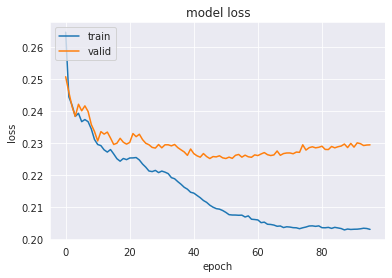

In [25]:
%autoreload 2
((X_valid_list, y_valid_list), 
 (X_test_list, y_test_list),
 history_list, 

 #scores_valid_list,
 #scores_test_list, 

 #function_values_valid_list, 
 #function_values_test_list, 

 #polynomial_dict_valid_list,
 #polynomial_dict_test_list,

 #distrib_dict_valid_list,
 #distrib_dict_test_list,

 model_list) = interpretation_net_training(lambda_net_train_dataset_list, 
                                           lambda_net_valid_dataset_list, 
                                           lambda_net_test_dataset_list)



In [26]:
model_list[-1].summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input (InputLayer)              [(None, 601)]        0                                            
__________________________________________________________________________________________________
hidden1_4096 (Dense)            (None, 4096)         2465792     input[0][0]                      
__________________________________________________________________________________________________
activation1_relu (Activation)   (None, 4096)         0           hidden1_4096[0][0]               
__________________________________________________________________________________________________
hidden2_2048 (Dense)            (None, 2048)         8390656     activation1_relu[0][0]           
______________________________________________________________________________________________

In [27]:
#polynomial_dict_valid_list = []
polynomial_dict_test_list = []  
runtimes_list = []

for lambda_net_valid_dataset, lambda_net_test_dataset in zip(lambda_net_valid_dataset_list, lambda_net_test_dataset_list):

    #polynomial_dict_valid = {'lstsq_lambda_pred_polynomials': lambda_net_valid_dataset.lstsq_lambda_pred_polynomial_list,
    #                        'lstsq_target_polynomials': lambda_net_valid_dataset.lstsq_target_polynomial_list,
    #                        'target_polynomials': lambda_net_valid_dataset.target_polynomial_list}    

    polynomial_dict_test = {'lstsq_lambda_pred_polynomials': lambda_net_test_dataset.lstsq_lambda_pred_polynomial_list,
                            'lstsq_target_polynomials': lambda_net_test_dataset.lstsq_target_polynomial_list,
                            'target_polynomials': lambda_net_test_dataset.target_polynomial_list}    

    #polynomial_dict_valid_list.append(polynomial_dict_valid)  
    polynomial_dict_test_list.append(polynomial_dict_test)
    runtimes_list.append({})
    



In [28]:
print('---------------------------------------------------------------------------------------------------------------------------')
print('------------------------------------------------------- PREDICT INET ------------------------------------------------------')

start = time.time() 

for i, (X_test, model) in enumerate(zip(X_test_list, model_list)):
    #y_test_pred = model.predict(X_test)    
    #print(model.summary())
    #print(X_test.shape)
    y_test_pred, inet_runtime = make_inet_prediction(model, X_test, network_data=None, lambda_trained_normalized=False, inet_training_normalized=normalize_inet_data, normalization_parameter_dict=None)
    #print(y_test_pred.shape)   
    polynomial_dict_test_list[i]['inet_polynomials'] = y_test_pred
    runtimes_list[i]['inet_runtime'] =  np.array([inet_runtime/len(lambda_net_test_dataset.target_polynomial_list) for _ in range(len(lambda_net_test_dataset.target_polynomial_list))])
    

end = time.time()     
inet_train_time = (end - start) 
minutes, seconds = divmod(int(inet_train_time), 60)
hours, minutes = divmod(minutes, 60)        
print('Predict Time: ' +  f'{hours:d}:{minutes:02d}:{seconds:02d}')     
print('---------------------------------------------------------------------------------------------------------------------------')

---------------------------------------------------------------------------------------------------------------------------
------------------------------------------------------- PREDICT INET ------------------------------------------------------
Predict Time: 0:00:00
---------------------------------------------------------------------------------------------------------------------------


In [29]:
if symbolic_metamodeling_poly_evaluation:
    print('-------------------------------------------------- CALCULATE METAMODEL POLY -----------------------------------------------')

    start = time.time() 

    for i, lambda_net_test_dataset in enumerate(lambda_net_test_dataset_list): 
        metamodel_functions_test, metamodel_runtimes = symbolic_metamodeling_function_generation(lambda_net_test_dataset, return_expression='approx', function_metamodeling=False, force_polynomial=True)
        polynomial_dict_test_list[i]['metamodel_poly'] = metamodel_functions_test     
        runtimes_list[i]['metamodel_poly_runtime'] = metamodel_runtimes

    end = time.time()     
    inet_train_time = (end - start) 
    minutes, seconds = divmod(int(inet_train_time), 60)
    hours, minutes = divmod(minutes, 60)        
    print('Metamodel Poly Optimization Time: ' +  f'{hours:d}:{minutes:02d}:{seconds:02d}')     
    print('---------------------------------------------------------------------------------------------------------------------------') 

In [30]:
if symbolic_metamodeling_evaluation:
    print('---------------------------------------------------- CALCULATE METAMODEL --------------------------------------------------')

    start = time.time() 

    for i, lambda_net_test_dataset in enumerate(lambda_net_test_dataset_list): 
        metamodel_functions_test, metamodel_runtimes = symbolic_metamodeling_function_generation(lambda_net_test_dataset, return_expression='approx', function_metamodeling=False, force_polynomial=False)
        polynomial_dict_test_list[i]['metamodel_functions'] = metamodel_functions_test       
        runtimes_list[i]['metamodel_functions_runtime'] = metamodel_runtimes
        
    end = time.time()     
    inet_train_time = (end - start) 
    minutes, seconds = divmod(int(inet_train_time), 60)
    hours, minutes = divmod(minutes, 60)        
    print('Metamodel Optimization Time: ' +  f'{hours:d}:{minutes:02d}:{seconds:02d}')     
    print('---------------------------------------------------------------------------------------------------------------------------') 

In [31]:
if symbolic_metamodeling_function_evaluation:
    print('----------------------------------------------- CALCULATE METAMODEL FUNCTION ----------------------------------------------')

    start = time.time() 

    for i, lambda_net_test_dataset in enumerate(lambda_net_test_dataset_list): 
        metamodel_functions_test, metamodel_runtimes = symbolic_metamodeling_function_generation(lambda_net_test_dataset, return_expression='approx', function_metamodeling=True)
        polynomial_dict_test_list[i]['metamodel_functions_no_GD'] = metamodel_functions_test   
        runtimes_list[i]['metamodel_functions_no_GD_runtime'] = metamodel_runtimes

    end = time.time()     
    inet_train_time = (end - start) 
    minutes, seconds = divmod(int(inet_train_time), 60)
    hours, minutes = divmod(minutes, 60)        
    print('Metamodel Function Optimization Time: ' +  f'{hours:d}:{minutes:02d}:{seconds:02d}')     
    print('---------------------------------------------------------------------------------------------------------------------------') 

In [32]:
if symbolic_regression_evaluation:
    print('----------------------------------------- CALCULATE SYMBOLIC REGRESSION FUNCTION ------------------------------------------')

    start = time.time() 

    for i, lambda_net_test_dataset in enumerate(lambda_net_test_dataset_list): 
        symbolic_regression_functions_test, symbolic_regression_runtimes = symbolic_regression_function_generation(lambda_net_test_dataset)
        polynomial_dict_test_list[i]['symbolic_regression_functions'] = symbolic_regression_functions_test    
        runtimes_list[i]['symbolic_regression_runtime'] = symbolic_regression_runtimes

    end = time.time()     
    inet_train_time = (end - start) 
    minutes, seconds = divmod(int(inet_train_time), 60)
    hours, minutes = divmod(minutes, 60)        
    print('Symbolic Regression Optimization Time: ' +  f'{hours:d}:{minutes:02d}:{seconds:02d}')     
    print('---------------------------------------------------------------------------------------------------------------------------')    

In [33]:
#%autoreload 2
if per_network_evaluation:
    print('------------------------------------------------ CALCULATE PER NETWORK POLY -----------------------------------------------')

    start = time.time() 

    for i, lambda_net_test_dataset in enumerate(lambda_net_test_dataset_list): 
        per_network_poly_test = per_network_poly_generation(lambda_net_test_dataset, optimization_type='scipy')
        polynomial_dict_test_list[i]['per_network_polynomials'] = per_network_poly_test       

    end = time.time()     
    inet_train_time = (end - start) 
    minutes, seconds = divmod(int(inet_train_time), 60)
    hours, minutes = divmod(minutes, 60)        
    print('Per Network Optimization Time: ' +  f'{hours:d}:{minutes:02d}:{seconds:02d}')     
    print('---------------------------------------------------------------------------------------------------------------------------')

In [34]:
#%load_ext autoreload

In [35]:
#%autoreload 2
print('------------------------------------------------ CALCULATE FUNCTION VALUES ------------------------------------------------')                

start = time.time() 

function_values_test_list = []
for lambda_net_test_dataset, polynomial_dict_test in zip(lambda_net_test_dataset_list, polynomial_dict_test_list):
    function_values_test = calculate_all_function_values(lambda_net_test_dataset, polynomial_dict_test)
    function_values_test_list.append(function_values_test)

end = time.time()     
inet_train_time = (end - start) 
minutes, seconds = divmod(int(inet_train_time), 60)
hours, minutes = divmod(minutes, 60)        
print('FV Calculation Time: ' +  f'{hours:d}:{minutes:02d}:{seconds:02d}')     
print('---------------------------------------------------------------------------------------------------------------------------')

------------------------------------------------ CALCULATE FUNCTION VALUES ------------------------------------------------
True


[Parallel(n_jobs=10)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done  30 tasks      | elapsed:    1.3s
[Parallel(n_jobs=10)]: Done 100 out of 100 | elapsed:    1.5s finished
[Parallel(n_jobs=10)]: Using backend ThreadingBackend with 10 concurrent workers.


True


[Parallel(n_jobs=10)]: Done  30 tasks      | elapsed:    0.1s
[Parallel(n_jobs=10)]: Done 100 out of 100 | elapsed:    0.3s finished
[Parallel(n_jobs=10)]: Using backend ThreadingBackend with 10 concurrent workers.


True


[Parallel(n_jobs=10)]: Done  30 tasks      | elapsed:    0.1s
[Parallel(n_jobs=10)]: Done 100 out of 100 | elapsed:    0.3s finished
[Parallel(n_jobs=10)]: Using backend ThreadingBackend with 10 concurrent workers.


False
metamodel_poly
Exit <class 'KeyError'>
metamodel_functions
Exit <class 'KeyError'>
metamodel_functions_no_GD
Exit <class 'KeyError'>
symbolic_regression_functions
Exit <class 'KeyError'>
per_network_polynomials
Exit <class 'KeyError'>
FV Calculation Time: 0:00:14
---------------------------------------------------------------------------------------------------------------------------


[Parallel(n_jobs=10)]: Done  30 tasks      | elapsed:    0.7s
[Parallel(n_jobs=10)]: Done 100 out of 100 | elapsed:    0.8s finished


In [36]:
print('----------------------------------------------------- CALCULATE SCORES ----------------------------------------------------')                

start = time.time() 

scores_test_list = []
distrib_dict_test_list = []
runtime_distrib_list = []
for function_values_test, polynomial_dict_test, runtimes_dict in zip(function_values_test_list, polynomial_dict_test_list, runtimes_list):
    scores_test, distrib_test = evaluate_all_predictions(function_values_test, polynomial_dict_test)
    scores_test_list.append(scores_test)
    distrib_dict_test_list.append(distrib_test)
    runtimes_list.append(pd.DataFrame(runtimes_dict))

end = time.time()     
inet_train_time = (end - start) 
minutes, seconds = divmod(int(inet_train_time), 60)
hours, minutes = divmod(minutes, 60)        
print('Score Calculation Time: ' +  f'{hours:d}:{minutes:02d}:{seconds:02d}')     
print('---------------------------------------------------------------------------------------------------------------------------')
print('---------------------------------------------------------------------------------------------------------------------------')         


----------------------------------------------------- CALCULATE SCORES ----------------------------------------------------
lambda_preds_VS_target_polynomials
lambda_preds_VS_lstsq_lambda_pred_polynomials
lambda_preds_VS_lstsq_target_polynomials
lambda_preds_VS_inet_polynomials
target_polynomials_VS_lstsq_lambda_pred_polynomials
target_polynomials_VS_lstsq_target_polynomials
target_polynomials_VS_inet_polynomials
lstsq_lambda_pred_polynomials_VS_lstsq_target_polynomials
lstsq_lambda_pred_polynomials_VS_inet_polynomials
lstsq_target_polynomials_VS_inet_polynomials
Score Calculation Time: 0:00:01
---------------------------------------------------------------------------------------------------------------------------
---------------------------------------------------------------------------------------------------------------------------


In [37]:
identifier_type = 'epochs' if samples_list == None else 'samples'
save_results(scores_list=scores_test_list, by=identifier_type)

## Evaluate Interpretation Net

In [38]:
if nas:
    for trial in history_list[-1]: 
        print(trial.summary())

In [39]:
if len(model_list) >= 1:
    print(model_list[-1].summary())
    print(model_list[-1].get_config())

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input (InputLayer)              [(None, 601)]        0                                            
__________________________________________________________________________________________________
hidden1_4096 (Dense)            (None, 4096)         2465792     input[0][0]                      
__________________________________________________________________________________________________
activation1_relu (Activation)   (None, 4096)         0           hidden1_4096[0][0]               
__________________________________________________________________________________________________
hidden2_2048 (Dense)            (None, 2048)         8390656     activation1_relu[0][0]           
______________________________________________________________________________________________

In [40]:
if evaluate_with_real_function:
    keys = ['inetPoly_VS_targetPoly_test', 'perNetworkPoly_VS_targetPoly_test', 'predLambda_VS_targetPoly_test', 'lstsqLambda_VS_targetPoly_test', 'lstsqTarget_VS_targetPoly_test']
else:
    keys = ['inetPoly_VS_predLambda_test', 'inetPoly_VS_lstsqLambda_test', 'perNetworkPoly_VS_predLambda_test', 'perNetworkPoly_VS_lstsqLambda_test', 'lstsqLambda_VS_predLambda_test', 'predLambda_VS_targetPoly_test']

In [41]:
#0.183	0.234	3.604	0.143	0.687	2.559	0.215

In [42]:
scores_test_list[-1]

MAE  RMSE   MAPE  \
lambda_preds_VS_target_polynomials                   NaN   NaN    NaN   
lambda_preds_VS_lstsq_lambda_pred_polynomials        NaN   NaN    NaN   
lambda_preds_VS_lstsq_target_polynomials             NaN   NaN    NaN   
lambda_preds_VS_inet_polynomials                     NaN   NaN    NaN   
target_polynomials_VS_lstsq_lambda_pred_polynom... 0.135 0.203 11.913   
target_polynomials_VS_lstsq_target_polynomials     0.690 0.951 66.685   
target_polynomials_VS_inet_polynomials             0.196 0.275 18.319   
lstsq_lambda_pred_polynomials_VS_lstsq_target_p... 0.694 0.956 42.757   
lstsq_lambda_pred_polynomials_VS_inet_polynomials  0.232 0.317 13.095   
lstsq_target_polynomials_VS_inet_polynomials       0.806 1.095  1.868   

                                                    Accuracy  \
lambda_preds_VS_target_polynomials                       NaN   
lambda_preds_VS_lstsq_lambda_pred_polynomials            NaN   
lambda_preds_VS_lstsq_target_polynomials                 NaN   
lambda_preds_VS_inet_polynomials                         NaN   
target_polynomials_VS_lstsq_lambda_pred_polynom...     0.297   
target_polynomials_VS_lstsq_target_polynomials         0.054   
target_polynomials_VS_inet_polynomials                 0.226   
lstsq_lambda_pred_polynomials_VS_lstsq_target_p...     0.056   
lstsq_lambda_pred_polynomials_VS_inet_polynomials      0.151   
lstsq_target_polynomials_VS_inet_polynomials           0.040   

                                                    Accuracy Multilabel  \
lambda_preds_VS_target_polynomials                                  NaN   
lambda_preds_VS_lstsq_lambda_pred_polynomials                       NaN   
lambda_preds_VS_lstsq_target_polynomials                            NaN   
lambda_preds_VS_inet_polynomials                                    NaN   
target_polynomials_VS_lstsq_lambda_pred_polynom...                0.000   
target_polynomials_VS_lstsq_target_polynomials                    0.000   
target_polynomials_VS_inet_polynomials                            0.000   
lstsq_lambda_pred_polynomials_VS_lstsq_target_p...                0.000   
lstsq_lambda_pred_polynomials_VS_inet_polynomials                 0.000   
lstsq_target_polynomials_VS_inet_polynomials                      0.000   

                                                    MAE FV  RMSE FV  MAPE FV  \
lambda_preds_VS_target_polynomials                   0.116    0.149    2.783   
lambda_preds_VS_lstsq_lambda_pred_polynomials        0.030    0.040    0.767   
lambda_preds_VS_lstsq_target_polynomials             0.215    0.283   12.457   
lambda_preds_VS_inet_polynomials                     0.228    0.282   15.684   
target_polynomials_VS_lstsq_lambda_pred_polynom...   0.118    0.152    2.576   
target_polynomials_VS_lstsq_target_polynomials       0.200    0.263    4.754   
target_polynomials_VS_inet_polynomials               0.236    0.307    3.376   
lstsq_lambda_pred_polynomials_VS_lstsq_target_p...   0.216    0.283    4.548   
lstsq_lambda_pred_polynomials_VS_inet_polynomials    0.229    0.284    3.210   
lstsq_target_polynomials_VS_inet_polynomials         0.313    0.406    4.222   

                                                    R2 FV  RAAE FV  RMAE FV  \
lambda_preds_VS_target_polynomials                  0.753    0.375    1.757   
lambda_preds_VS_lstsq_lambda_pred_polynomials       0.982    0.098    0.635   
lambda_preds_VS_lstsq_target_polynomials            0.147    0.689    3.579   
lambda_preds_VS_inet_polynomials                    0.201    0.712    2.631   
target_polynomials_VS_lstsq_lambda_pred_polynom...  0.802    0.342    1.760   
target_polynomials_VS_lstsq_target_polynomials      0.422    0.573    3.197   
target_polynomials_VS_inet_polynomials              0.214    0.673    3.203   
lstsq_lambda_pred_polynomials_VS_lstsq_target_p...  0.153    0.687    3.592   
lstsq_lambda_pred_polynomials_VS_inet_polynomials   0.198    0.712    2.705   
lstsq_target_polynomials_VS_inet_polynomials   

In [43]:
distrib_dict_test_list[-1]['MAE']

L-0   L-1   L-2   L-3  \
lambda_preds_VS_target_polynomials                 0.121 0.127 0.092 0.133   
lambda_preds_VS_lstsq_lambda_pred_polynomials      0.029 0.023 0.035 0.021   
lambda_preds_VS_lstsq_target_polynomials           0.211 0.256 0.148 0.242   
lambda_preds_VS_inet_polynomials                   0.269 0.279 0.152 0.207   
target_polynomials_VS_lstsq_lambda_pred_polynom... 0.120 0.127 0.092 0.133   
target_polynomials_VS_lstsq_target_polynomials     0.193 0.230 0.148 0.202   
target_polynomials_VS_inet_polynomials             0.267 0.276 0.136 0.225   
lstsq_lambda_pred_polynomials_VS_lstsq_target_p... 0.214 0.256 0.145 0.241   
lstsq_lambda_pred_polynomials_VS_inet_polynomials  0.269 0.279 0.151 0.204   
lstsq_target_polynomials_VS_inet_polynomials       0.346 0.370 0.194 0.284   

                                                     L-4   L-5   L-6   L-7  \
lambda_preds_VS_target_polynomials                 0.078 0.061 0.091 0.117   
lambda_preds_VS_lstsq_lambda_pred_polynomials      0.032 0.027 0.028 0.021   
lambda_preds_VS_lstsq_target_polynomials           0.151 0.106 0.196 0.206   
lambda_preds_VS_inet_polynomials                   0.212 0.109 0.194 0.220   
target_polynomials_VS_lstsq_lambda_pred_polynom... 0.082 0.065 0.095 0.117   
target_polynomials_VS_lstsq_target_polynomials     0.144 0.100 0.181 0.177   
target_polynomials_VS_inet_polynomials             0.218 0.113 0.192 0.233   
lstsq_lambda_pred_polynomials_VS_lstsq_target_p... 0.155 0.106 0.198 0.208   
lstsq_lambda_pred_polynomials_VS_inet_polynomials  0.217 0.112 0.195 0.221   
lstsq_target_polynomials_VS_inet_polynomials       0.283 0.149 0.280 0.281   

                                                     L-8   L-9  L-10  L-11  \
lambda_preds_VS_target_polynomials                 0.134 0.111 0.090 0.161   
lambda_preds_VS_lstsq_lambda_pred_polynomials      0.038 0.046 0.035 0.040   
lambda_preds_VS_lstsq_target_polynomials           0.238 0.195 0.162 0.297   
lambda_preds_VS_inet_polynomials                   0.337 0.169 0.187 0.318   
target_polynomials_VS_lstsq_lambda_pred_polynom... 0.136 0.115 0.094 0.162   
target_polynomials_VS_lstsq_target_polynomials     0.234 0.192 0.160 0.295   
target_polynomials_VS_inet_polynomials             0.336 0.195 0.181 0.307   
lstsq_lambda_pred_polynomials_VS_lstsq_target_p... 0.239 0.196 0.161 0.295   
lstsq_lambda_pred_polynomials_VS_inet_polynomials  0.341 0.173 0.191 0.319   
lstsq_target_polynomials_VS_inet_polynomials       0.422 0.248 0.253 0.428   

                                                    L-12  L-13  L-14  L-15  \
lambda_preds_VS_target_polynomials                 0.138 0.089 0.108 0.117   
lambda_preds_VS_lstsq_lambda_pred_polynomials      0.020 0.018 0.027 0.033   
lambda_preds_VS_lstsq_target_polynomials           0.258 0.162 0.231 0.210   
lambda_preds_VS_inet_polynomials                   0.218 0.117 0.206 0.230   
target_polynomials_VS_lstsq_lambda_pred_polynom... 0.140 0.092 0.109 0.117   
target_polynomials_VS_lstsq_target_polynomials     0.243 0.144 0.200 0.188   
target_polynomials_VS_inet_polynomials             0.233 0.129 0.218 0.217   
lstsq_lambda_pred_polynomials_VS_lstsq_target_p... 0.258 0.165 0.232 0.208   
lstsq_lambda_pred_polynomials_VS_inet_polynomials  0.219 0.119 0.203 0.229   
lstsq_target_polynomials_VS_inet_polynomials       0.321 0.196 0.300 0.294   

                                                    L-16  L-17  L-18  L-19  \
lambda_preds_VS_target_polynomials                 0.108 0.119 0.139 0.099   
lambda_preds_VS_lstsq_lambda_pred_polynomials      0.028 0.045 0.020 0.036   
lambda_preds_VS_lstsq_target_polynomials           0.191 0.193 0.223 0.218   
lambda_preds_VS_inet_polynomials                   0.246 0.275 0.176 0.271   
target_polynomials_VS_lstsq_lambda_pred_polynom... 0.109 0.122 0.139 0.103   
target_polynomials_VS_lstsq_target_polynomials     0.186 0.171 0.184 0.218   
target_polynomials_VS_inet_polynomials             0.247 0.259 0.215 0.

In [44]:
distrib_dict_test_list[-1]['R2']

L-0    L-1   L-2    L-3  \
lambda_preds_VS_target_polynomials                  0.766  0.752 0.866  0.516   
lambda_preds_VS_lstsq_lambda_pred_polynomials       0.987  0.992 0.979  0.987   
lambda_preds_VS_lstsq_target_polynomials            0.263 -0.042 0.625 -0.611   
lambda_preds_VS_inet_polynomials                   -0.015 -0.046 0.656 -0.057   
target_polynomials_VS_lstsq_lambda_pred_polynom...  0.787  0.807 0.856  0.675   
target_polynomials_VS_lstsq_target_polynomials      0.411  0.352 0.594  0.235   
target_polynomials_VS_inet_polynomials             -0.143  0.035 0.678  0.066   
lstsq_lambda_pred_polynomials_VS_lstsq_target_p...  0.250 -0.034 0.637 -0.595   
lstsq_lambda_pred_polynomials_VS_inet_polynomials  -0.019 -0.044 0.660 -0.040   
lstsq_target_polynomials_VS_inet_polynomials       -0.164  0.021 0.501  0.125   

                                                     L-4   L-5   L-6    L-7  \
lambda_preds_VS_target_polynomials                 0.874 0.739 0.825  0.691   
lambda_preds_VS_lstsq_lambda_pred_polynomials      0.978 0.951 0.983  0.989   
lambda_preds_VS_lstsq_target_polynomials           0.491 0.228 0.137  0.018   
lambda_preds_VS_inet_polynomials                   0.085 0.246 0.240 -0.010   
target_polynomials_VS_lstsq_lambda_pred_polynom... 0.873 0.753 0.821  0.768   
target_polynomials_VS_lstsq_target_polynomials     0.598 0.468 0.314  0.452   
target_polynomials_VS_inet_polynomials             0.103 0.183 0.224  0.039   
lstsq_lambda_pred_polynomials_VS_lstsq_target_p... 0.477 0.256 0.113  0.001   
lstsq_lambda_pred_polynomials_VS_inet_polynomials  0.071 0.232 0.228 -0.013   
lstsq_target_polynomials_VS_inet_polynomials       0.088 0.147 0.104  0.043   

                                                      L-8   L-9  L-10  L-11  \
lambda_preds_VS_target_polynomials                  0.831 0.747 0.836 0.752   
lambda_preds_VS_lstsq_lambda_pred_polynomials       0.986 0.954 0.972 0.983   
lambda_preds_VS_lstsq_target_polynomials            0.442 0.196 0.422 0.100   
lambda_preds_VS_inet_polynomials                    0.008 0.480 0.333 0.009   
target_polynomials_VS_lstsq_lambda_pred_polynom...  0.841 0.795 0.824 0.822   
target_polynomials_VS_lstsq_target_polynomials      0.516 0.419 0.457 0.366   
target_polynomials_VS_inet_polynomials              0.047 0.431 0.336 0.317   
lstsq_lambda_pred_polynomials_VS_lstsq_target_p...  0.451 0.208 0.444 0.118   
lstsq_lambda_pred_polynomials_VS_inet_polynomials  -0.003 0.451 0.324 0.010   
lstsq_target_polynomials_VS_inet_polynomials       -0.020 0.327 0.231 0.082   

                                                    L-12   L-13   L-14  L-15  \
lambda_preds_VS_target_polynomials                 0.747  0.559  0.750 0.784   
lambda_preds_VS_lstsq_lambda_pred_polynomials      0.994  0.980  0.984 0.980   
lambda_preds_VS_lstsq_target_polynomials           0.108 -0.527 -0.161 0.278   
lambda_preds_VS_inet_polynomials                   0.445  0.320  0.201 0.164   
target_polynomials_VS_lstsq_lambda_pred_polynom... 0.799  0.685  0.819 0.796   
target_polynomials_VS_lstsq_target_polynomials     0.384  0.218  0.367 0.437   
target_polynomials_VS_inet_polynomials             0.452  0.309  0.332 0.194   
lstsq_lambda_pred_polynomials_VS_lstsq_target_p... 0.093 -0.534 -0.167 0.278   
lstsq_lambda_pred_polynomials_VS_inet_polynomials  0.442  0.319  0.220 0.158   
lstsq_target_polynomials_VS_inet_polynomials       0.299  0.187  0.160 0.140   

                                                     L-16  L-17   L-18  L-19  \
lambda_preds_VS_target_polynomials                  0.769 0.853  0.271 0.849   
lambda_preds_VS_lstsq_lambda_pred_polynomials       0.984 0.974  0.985 0.979   
lambda_preds_VS_lstsq_target_polynomials            0.194 0.564 -0.808 0.264   
lambda_preds_VS_inet_polynomials                   -0.156 0.132 -0.085 0.019   
target_polynomials_VS_lstsq_lambda_pred_polynom...  0.802 0.829  0.649 0.850   
target_polynomials_VS_lstsq_target_polynomials      0.352 0.5

In [45]:
runtimes_list[-1]

inet_runtime
0          0.003
1          0.003
2          0.003
3          0.003
4          0.003
..           ...
95         0.003
96         0.003
97         0.003
98         0.003
99         0.003

[100 rows x 1 columns]

In [46]:
paths_dict = generate_paths(path_type = 'interpretation_net_no_noise')

path_mae = './data/results/' + paths_dict['path_identifier_interpretation_net_data'] + '/mae_distrib_test_data_' + 'noise' + str(noise) + '.csv'
path_r2 = './data/results/' + paths_dict['path_identifier_interpretation_net_data'] + '/r2_distrib_test_data_' + 'noise' + str(noise) + '.csv'
path_runtimes = './data/results/' + paths_dict['path_identifier_interpretation_net_data'] + '/runtimes_' + 'noise' + str(noise) + '.csv'
path_fv = './data/results/' + paths_dict['path_identifier_interpretation_net_data'] + '/fvs_' + 'noise' + str(noise) + '.csv'
path_functions = './data/results/' + paths_dict['path_identifier_interpretation_net_data'] + '/functions_' + 'noise' + str(noise) + '.csv'


distrib_dict_test_list[-1]['MAE'].to_csv(path_mae)
distrib_dict_test_list[-1]['R2'].to_csv(path_r2)
runtimes_list[-1].to_csv(path_runtimes)

with open(path_fv, 'wb') as f:
    pickle.dump(function_values_test_list[-1], f, protocol=2)

with open(path_functions, 'wb') as f:
    pickle.dump(polynomial_dict_test_list[-1], f, protocol=2)


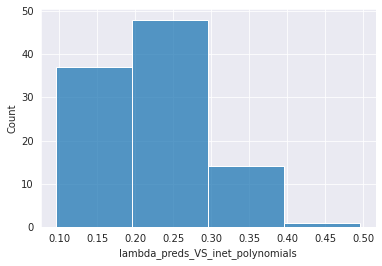

In [47]:
p = sns.histplot(distrib_dict_test_list[-1]['MAE'].loc['lambda_preds_VS_inet_polynomials'][distrib_dict_test_list[-1]['MAE'].loc['lambda_preds_VS_inet_polynomials'] < 50], binwidth=0.1)
#p.set(xlim=(0, 20))


[(0.0, 1.0)]

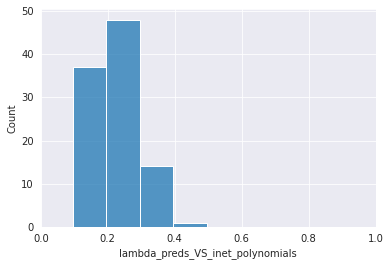

In [48]:
p = sns.histplot(distrib_dict_test_list[-1]['MAE'].loc['lambda_preds_VS_inet_polynomials'][distrib_dict_test_list[-1]['MAE'].loc['lambda_preds_VS_inet_polynomials'] < 50], binwidth=0.1)
p.set(xlim=(0, 1))


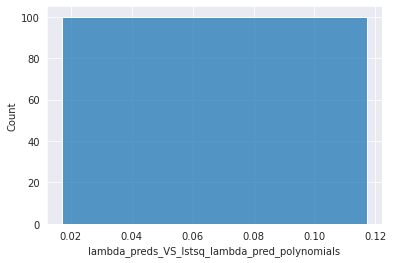

In [49]:
p = sns.histplot(distrib_dict_test_list[-1]['MAE'].loc['lambda_preds_VS_lstsq_lambda_pred_polynomials'][distrib_dict_test_list[-1]['MAE'].loc['lambda_preds_VS_lstsq_lambda_pred_polynomials'] < 50], binwidth=0.1)
#p.set(xlim=(0, 20))


[(0.0, 1.0)]

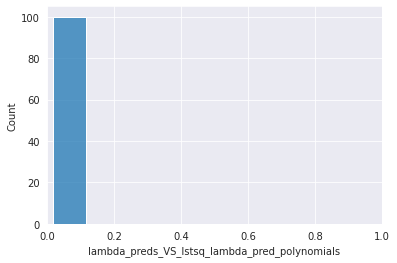

In [50]:
p = sns.histplot(distrib_dict_test_list[-1]['MAE'].loc['lambda_preds_VS_lstsq_lambda_pred_polynomials'][distrib_dict_test_list[-1]['MAE'].loc['lambda_preds_VS_lstsq_lambda_pred_polynomials'] < 50], binwidth=0.1)
p.set(xlim=(0, 1))


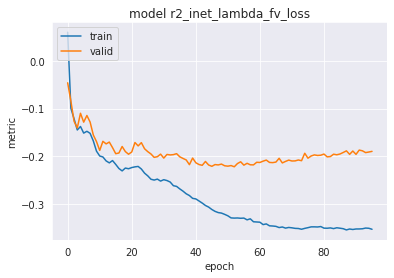

In [51]:
if not nas:
    history = history_list[-1]

    plt.plot(history[list(history.keys())[1]])
    try:
        plt.plot(history[list(history.keys())[len(history.keys())//2+1]]) 
    except:
        pass
    plt.title('model ' + list(history.keys())[1])
    plt.ylabel('metric')
    plt.xlabel('epoch')
    plt.legend(['train', 'valid'], loc='upper left')
    plt.savefig('./data/results/' + path_identifier_interpretation_net_data + '/metric_' + '_epoch_' + str(epochs_lambda).zfill(3) + '.png')


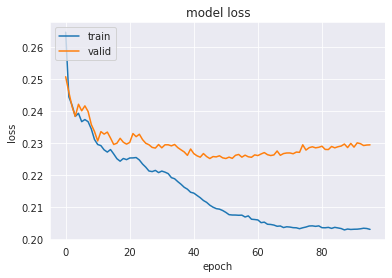

In [52]:
if not nas:
    history = history_list[-1]

    plt.plot(history['loss'])
    try:
        plt.plot(history['val_loss'])
    except:
        pass
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'valid'], loc='upper left')
    plt.savefig('./data/results/' + path_identifier_interpretation_net_data + '/loss_' + '_epoch_' + str(epochs_lambda).zfill(3) + '.png')    


### Multi Epoch/Sampes Analysis

### Generate Comparison Plots

In [53]:
if len(scores_test_list) > 1:
    plot_metric_list = ['MAE FV', 'RMSE FV', 'MAPE FV', 'R2 FV', 'RAAE FV', 'RMAE FV']

    generate_inet_comparison_plot(scores_test_list, plot_metric_list)

In [54]:
if len(scores_test_list) > 1:
    plot_metric_list = ['MAE FV']

    generate_inet_comparison_plot(scores_test_list, plot_metric_list)

In [55]:
if len(scores_test_list) > 1:
    plot_metric_list = ['R2 FV']

    generate_inet_comparison_plot(scores_test_list, plot_metric_list, ylim=(-5, 1))

#### Generate and Analyze Predictions for Random Function

In [56]:
distrib_dict_test_list[-1]['MAE']

L-0   L-1   L-2   L-3  \
lambda_preds_VS_target_polynomials                 0.121 0.127 0.092 0.133   
lambda_preds_VS_lstsq_lambda_pred_polynomials      0.029 0.023 0.035 0.021   
lambda_preds_VS_lstsq_target_polynomials           0.211 0.256 0.148 0.242   
lambda_preds_VS_inet_polynomials                   0.269 0.279 0.152 0.207   
target_polynomials_VS_lstsq_lambda_pred_polynom... 0.120 0.127 0.092 0.133   
target_polynomials_VS_lstsq_target_polynomials     0.193 0.230 0.148 0.202   
target_polynomials_VS_inet_polynomials             0.267 0.276 0.136 0.225   
lstsq_lambda_pred_polynomials_VS_lstsq_target_p... 0.214 0.256 0.145 0.241   
lstsq_lambda_pred_polynomials_VS_inet_polynomials  0.269 0.279 0.151 0.204   
lstsq_target_polynomials_VS_inet_polynomials       0.346 0.370 0.194 0.284   

                                                     L-4   L-5   L-6   L-7  \
lambda_preds_VS_target_polynomials                 0.078 0.061 0.091 0.117   
lambda_preds_VS_lstsq_lambda_pred_polynomials      0.032 0.027 0.028 0.021   
lambda_preds_VS_lstsq_target_polynomials           0.151 0.106 0.196 0.206   
lambda_preds_VS_inet_polynomials                   0.212 0.109 0.194 0.220   
target_polynomials_VS_lstsq_lambda_pred_polynom... 0.082 0.065 0.095 0.117   
target_polynomials_VS_lstsq_target_polynomials     0.144 0.100 0.181 0.177   
target_polynomials_VS_inet_polynomials             0.218 0.113 0.192 0.233   
lstsq_lambda_pred_polynomials_VS_lstsq_target_p... 0.155 0.106 0.198 0.208   
lstsq_lambda_pred_polynomials_VS_inet_polynomials  0.217 0.112 0.195 0.221   
lstsq_target_polynomials_VS_inet_polynomials       0.283 0.149 0.280 0.281   

                                                     L-8   L-9  L-10  L-11  \
lambda_preds_VS_target_polynomials                 0.134 0.111 0.090 0.161   
lambda_preds_VS_lstsq_lambda_pred_polynomials      0.038 0.046 0.035 0.040   
lambda_preds_VS_lstsq_target_polynomials           0.238 0.195 0.162 0.297   
lambda_preds_VS_inet_polynomials                   0.337 0.169 0.187 0.318   
target_polynomials_VS_lstsq_lambda_pred_polynom... 0.136 0.115 0.094 0.162   
target_polynomials_VS_lstsq_target_polynomials     0.234 0.192 0.160 0.295   
target_polynomials_VS_inet_polynomials             0.336 0.195 0.181 0.307   
lstsq_lambda_pred_polynomials_VS_lstsq_target_p... 0.239 0.196 0.161 0.295   
lstsq_lambda_pred_polynomials_VS_inet_polynomials  0.341 0.173 0.191 0.319   
lstsq_target_polynomials_VS_inet_polynomials       0.422 0.248 0.253 0.428   

                                                    L-12  L-13  L-14  L-15  \
lambda_preds_VS_target_polynomials                 0.138 0.089 0.108 0.117   
lambda_preds_VS_lstsq_lambda_pred_polynomials      0.020 0.018 0.027 0.033   
lambda_preds_VS_lstsq_target_polynomials           0.258 0.162 0.231 0.210   
lambda_preds_VS_inet_polynomials                   0.218 0.117 0.206 0.230   
target_polynomials_VS_lstsq_lambda_pred_polynom... 0.140 0.092 0.109 0.117   
target_polynomials_VS_lstsq_target_polynomials     0.243 0.144 0.200 0.188   
target_polynomials_VS_inet_polynomials             0.233 0.129 0.218 0.217   
lstsq_lambda_pred_polynomials_VS_lstsq_target_p... 0.258 0.165 0.232 0.208   
lstsq_lambda_pred_polynomials_VS_inet_polynomials  0.219 0.119 0.203 0.229   
lstsq_target_polynomials_VS_inet_polynomials       0.321 0.196 0.300 0.294   

                                                    L-16  L-17  L-18  L-19  \
lambda_preds_VS_target_polynomials                 0.108 0.119 0.139 0.099   
lambda_preds_VS_lstsq_lambda_pred_polynomials      0.028 0.045 0.020 0.036   
lambda_preds_VS_lstsq_target_polynomials           0.191 0.193 0.223 0.218   
lambda_preds_VS_inet_polynomials                   0.246 0.275 0.176 0.271   
target_polynomials_VS_lstsq_lambda_pred_polynom... 0.109 0.122 0.139 0.103   
target_polynomials_VS_lstsq_target_polynomials     0.186 0.171 0.184 0.218   
target_polynomials_VS_inet_polynomials             0.247 0.259 0.215 0.

In [57]:
index = 6

custom_representation_keys_fixed = ['target_polynomials']#['target_polynomials', 'lstsq_target_polynomials', 'lstsq_lambda_pred_polynomials']
custom_representation_keys_dynamic = ['inet_polynomials', 'per_network_polynomials']
sympy_representation_keys = ['metamodel_functions', 'symbolic_regression_functions']


print('------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------')

for key in polynomial_dict_test_list[-1].keys():
    if key in custom_representation_keys_fixed:
        print('------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------')
        print(key)        
        print_polynomial_from_coefficients(polynomial_dict_test_list[-1][key][index], force_complete_poly_representation=True, round_digits=4)
        print('MAE: ', distrib_dict_test_list[-1]['MAE'].loc['lambda_preds_VS_' + key][index])
        #print(polynomial_dict_test_list[-1][key][index])
    elif key in custom_representation_keys_dynamic:
        print('------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------')
        print(key)              
        print_polynomial_from_coefficients(polynomial_dict_test_list[-1][key][index], round_digits=4)
        print('MAE: ', distrib_dict_test_list[-1]['MAE'].loc['lambda_preds_VS_' + key][index])
        #print(polynomial_dict_test_list[-1][key][index])
    elif key in sympy_representation_keys:
        print('------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------')
        print(key)              
        display(polynomial_dict_test_list[-1][key][index])
        print('MAE: ', distrib_dict_test_list[-1]['MAE'].loc['lambda_preds_VS_' + key][index])
    else:
        pass

print('------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------')
print('------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------')


------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
target_polynomials


-0.7051*a*b*g - 0.0946*a*d*f + 0.4386*a*g*j - 0.823*a*h - 0.6039*c*d*j - 0.5039*c*h*j + 0.2206*c*j**2 + 0.4777*d*g + 0.9115*f*i*j - 0.4413*g**2

MAE:  0.091165416
------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
inet_polynomials


-0.0232999995350838*a*f*h - 0.0811000019311905*b**2*e - 0.00549999997019768*b*d*i - 0.0868000015616417*b*f - 0.160300001502037*b*h**2 - 0.379500009119511*d*h - 0.0322999991476536*e*g*j - 0.17960000038147*g**2 - 0.0975999981164932*h**2*j

MAE:  0.19375633
------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------


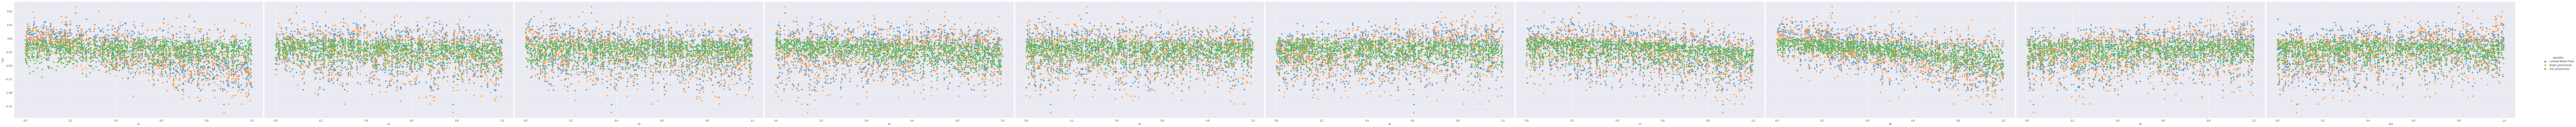

In [58]:
plot_and_save_single_polynomial_prediction_evaluation(lambda_net_test_dataset_list, 
                                                      function_values_test_list, 
                                                      polynomial_dict_test_list,
                                                      rand_index=index, 
                                                      plot_type=1)

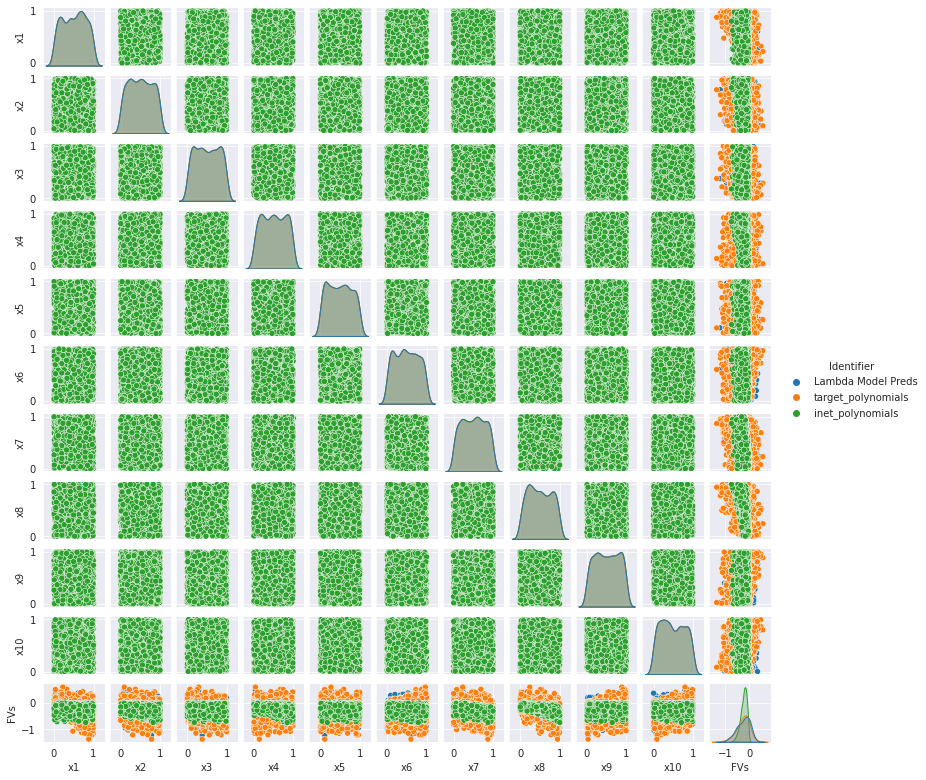

In [59]:
plot_and_save_single_polynomial_prediction_evaluation(lambda_net_test_dataset_list, 
                                                      function_values_test_list, 
                                                      polynomial_dict_test_list,
                                                      rand_index=index, 
                                                      plot_type=2)

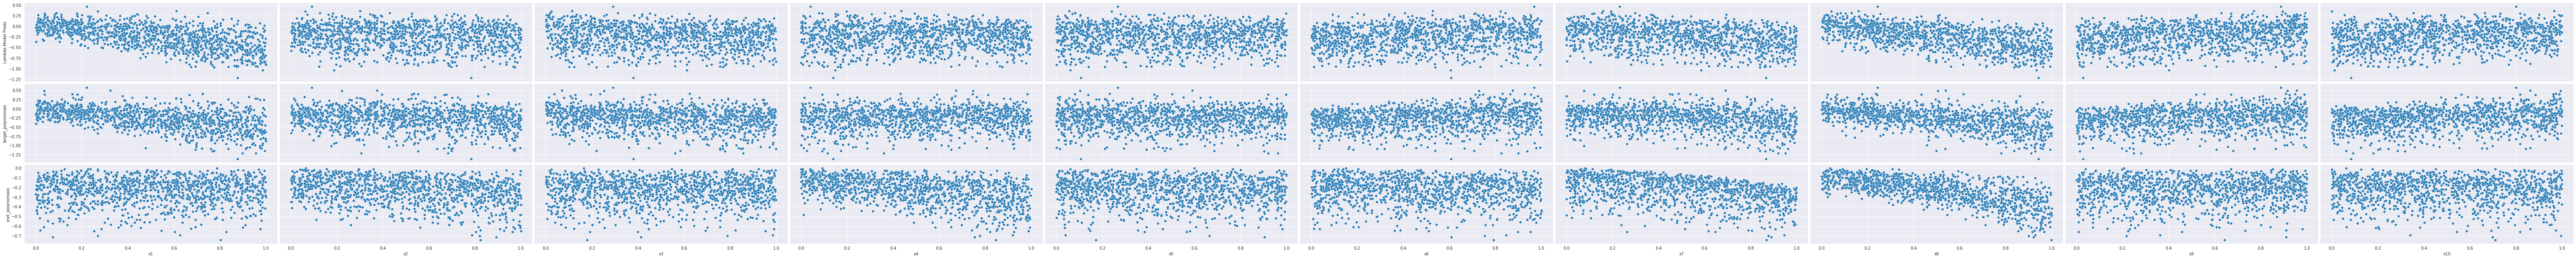

In [60]:
plot_and_save_single_polynomial_prediction_evaluation(lambda_net_test_dataset_list, 
                                                      function_values_test_list, 
                                                      polynomial_dict_test_list,
                                                      rand_index=index, 
                                                      plot_type=3)

In [61]:
runtimes_list[-1].values

array([[0.00285044],
       [0.00285044],
       [0.00285044],
       [0.00285044],
       [0.00285044],
       [0.00285044],
       [0.00285044],
       [0.00285044],
       [0.00285044],
       [0.00285044],
       [0.00285044],
       [0.00285044],
       [0.00285044],
       [0.00285044],
       [0.00285044],
       [0.00285044],
       [0.00285044],
       [0.00285044],
       [0.00285044],
       [0.00285044],
       [0.00285044],
       [0.00285044],
       [0.00285044],
       [0.00285044],
       [0.00285044],
       [0.00285044],
       [0.00285044],
       [0.00285044],
       [0.00285044],
       [0.00285044],
       [0.00285044],
       [0.00285044],
       [0.00285044],
       [0.00285044],
       [0.00285044],
       [0.00285044],
       [0.00285044],
       [0.00285044],
       [0.00285044],
       [0.00285044],
       [0.00285044],
       [0.00285044],
       [0.00285044],
       [0.00285044],
       [0.00285044],
       [0.00285044],
       [0.00285044],
       [0.002

In [62]:
distrib_dict_test_list[-1]['MAE'].loc['lambda_preds_VS_inet_polynomials'].values

array([0.26880145, 0.27857435, 0.15218076, 0.20725496, 0.21184044,
       0.10902204, 0.19375633, 0.22036888, 0.3373095 , 0.16872118,
       0.18692695, 0.31788135, 0.21837151, 0.11746541, 0.20600757,
       0.22960639, 0.24571812, 0.27544907, 0.17602184, 0.2705026 ,
       0.1385124 , 0.22471309, 0.31477186, 0.13891472, 0.34605923,
       0.17087507, 0.34607628, 0.33104625, 0.1985718 , 0.18822853,
       0.23881565, 0.25622582, 0.29333463, 0.23765223, 0.20783672,
       0.24600185, 0.3335417 , 0.38632628, 0.27981287, 0.27871314,
       0.19650999, 0.37051412, 0.09611729, 0.24777448, 0.24436665,
       0.11067005, 0.15680835, 0.41873804, 0.26088187, 0.22912373,
       0.19042628, 0.2526154 , 0.21790871, 0.20450678, 0.28779414,
       0.15703359, 0.23722456, 0.22992   , 0.2397248 , 0.1823187 ,
       0.14312464, 0.3767398 , 0.17350236, 0.18186167, 0.19775864,
       0.16024311, 0.29124463, 0.18126668, 0.15741703, 0.26732215,
       0.24578834, 0.18322009, 0.12023762, 0.21273059, 0.27289

In [63]:
distrib_dict_test_list[-1]['MAE'].loc['lambda_preds_VS_symbolic_regression_functions'].values

KeyError: 'lambda_preds_VS_symbolic_regression_functions'

In [ ]:
distrib_dict_test_list[-1]['MAE'].loc['lambda_preds_VS_metamodel_functions'].values

In [64]:
distrib_dict_test_list[-1]['R2'].loc['lambda_preds_VS_inet_polynomials'].values

array([-0.01476891, -0.0459417 ,  0.65599229, -0.05696721,  0.08473619,
        0.24586604,  0.23968575, -0.00970418,  0.00807433,  0.47954279,
        0.3326544 ,  0.00886549,  0.44500265,  0.31970652,  0.20144372,
        0.16367888, -0.15649009,  0.13172307, -0.08527261,  0.01877854,
        0.51084047,  0.06536157,  0.37937838,  0.3163822 , -0.00488999,
        0.61912672, -0.06711928,  0.13049809,  0.12847576,  0.14360938,
       -0.11249644,  0.33219032, -0.13064763,  0.13859433,  0.37184038,
       -0.03086822,  0.12610015, -0.33116712, -0.23892261,  0.5473704 ,
        0.62319524, -0.40331808,  0.51693609,  0.55206452,  0.14396189,
        0.62471835,  0.13083186,  0.06694308, -0.11828676,  0.42130565,
        0.59493563,  0.34785698, -0.73117499, -0.01568705,  0.0085936 ,
        0.14205978,  0.01372364,  0.09504471,  0.51885845,  0.45785002,
        0.34174891,  0.25292293,  0.42339111,  0.40064945,  0.28081936,
        0.22881688,  0.14886133,  0.14224169,  0.52946048,  0.08

In [ ]:
distrib_dict_test_list[-1]['R2'].loc['lambda_preds_VS_symbolic_regression_functions'].values

In [ ]:
distrib_dict_test_list[-1]['R2'].loc['lambda_preds_VS_metamodel_functions'].values

In [ ]:
STOP

# BENCHMARK (RANDOM GUESS) EVALUATION

In [ ]:
list_of_random_polynomials = np.random.uniform(low=-10, high=10, size=(len(lambda_net_test_dataset_list[-1]), sparsity))

In [ ]:
true_fv_test = parallel_fv_calculation_from_polynomial(lambda_net_test_dataset_list[-1].target_polynomial_list, lambda_net_test_dataset_list[-1].X_test_data_list, force_complete_poly_representation=True)
random_fv_test = parallel_fv_calculation_from_polynomial(list_of_random_polynomials, lambda_net_test_dataset_list[-1].X_test_data_list, force_complete_poly_representation=True)

In [ ]:
print('Random Guess Error Coefficients: ' + str(np.round(mean_absolute_error(lambda_net_test_dataset_list[-1].target_polynomial_list, list_of_random_polynomials), 4)))

In [ ]:
print('Random Guess Error FVs: ' + str(np.round(mean_absolute_error_function_values(true_fv_test, random_fv_test), 4)))

# BENCHMARK (EDUCATED GUESS/MEAN PREDICTION) EVALUATION

In [ ]:
true_fv_train = parallel_fv_calculation_from_polynomial(lambda_net_test_dataset_list[-1].target_polynomial_list, lambda_net_test_dataset_list[-1].X_test_data_list, force_complete_poly_representation=True)

mean_fv = np.mean(true_fv_train)
mean_fv_pred_test = [mean_fv for _ in range(true_fv_test.shape[0])]

In [ ]:
print('Educated Guess/Mean Prediction Error FVs: ' + str(np.round(mean_absolute_error_function_values(true_fv_test, mean_fv_pred_test), 4)))

In [ ]:
%%script false --no-raise-error

base_model = generate_base_model()
random_evaluation_dataset = np.random.uniform(low=x_min, high=x_max, size=(random_evaluation_dataset_size, n))
#random_evaluation_dataset = lambda_train_input_train_split[0]#lambda_train_input[0] #JUST [0] HERE BECAUSE EVALUATION ALWAYS ON THE SAME DATASET FOR ALL!!
list_of_monomial_identifiers_numbers = np.array([list(monomial_identifiers) for monomial_identifiers in list_of_monomial_identifiers]).astype(float)


loss_function = mean_absolute_error_tf_fv_lambda_extended_wrapper(random_evaluation_dataset, list_of_monomial_identifiers_numbers, base_model)      

X_train = X_train_list[-1].values[:,1:]
y_train = y_train_list[-1].values[:,2:]

#X_train = X_train[:,1:]
y_train_model = np.hstack((y_train, X_train))

print('seed_in_inet_training = ' + str(seed_in_inet_training), loss_function(y_train_model, y_train))


seed_in_inet_training = False

loss_function = mean_absolute_error_tf_fv_lambda_extended_wrapper(random_evaluation_dataset, list_of_monomial_identifiers_numbers, base_model)      

X_train = X_train_list[-1].values[:,1:]
y_train = y_train_list[-1].values[:,2:]

X_train = X_train[:,1:]
y_train_model = np.hstack((y_train, X_train))

print('seed_in_inet_training = ' + str(seed_in_inet_training), loss_function(y_train_model, y_train))

seed_in_inet_training = True



In [ ]:
lambda_net_test_dataset = lambda_net_test_dataset_list[-1]
current_jobs = 1

lr=0.5
max_steps = 100
early_stopping=10
restarts=2
per_network_dataset_size = 500

list_of_monomial_identifiers_numbers = np.array([list(monomial_identifiers) for monomial_identifiers in list_of_monomial_identifiers]).astype(float)  

if n_jobs != -1:
    n_jobs_per_network = min(n_jobs, os.cpu_count() // current_jobs)
else: 
    n_jobs_per_network = os.cpu_count() // current_jobs - 1

printing = True if n_jobs_per_network == 1 else False


lambda_network_weights_list = np.array(lambda_net_test_dataset.weight_list)
if evaluate_with_real_function: #target polynomial as inet target
    poly_representation_list = np.array(lambda_net_test_dataset.target_polynomial_list)
else: #lstsq lambda pred polynomial as inet target
    poly_representation_list = np.array(lambda_net_test_dataset.lstsq_lambda_pred_polynomial_list)


config = {
         'n': n,
         'inet_loss': inet_loss,
         'sparsity': sparsity,
         'lambda_network_layers': lambda_network_layers,
         'interpretation_net_output_shape': interpretation_net_output_shape,
         'RANDOM_SEED': RANDOM_SEED,
         'nas': nas,
         'number_of_lambda_weights': number_of_lambda_weights,
         'interpretation_net_output_monomials': interpretation_net_output_monomials,
         #'list_of_monomial_identifiers': list_of_monomial_identifiers,
         'x_min': x_min,
         'x_max': x_max,
         }


lambda_network_weights = lambda_network_weights_list[0]
poly_representation = poly_representation_list[0]



per_network_poly_optimization_tf(per_network_dataset_size, 
                                lambda_network_weights, 
                                  list_of_monomial_identifiers_numbers, 
                                  config, 
                                  lr=lr, 
                                  max_steps = max_steps, 
                                  early_stopping=early_stopping, 
                                  restarts=restarts, 
                                  printing=True)


# Evaluate Real Dataset


##  Auto MPG-Dataset

In [ ]:
interpretation_possible_autoMPG = False
print_head_autoMPG = None

url_autoMPG = 'http://archive.ics.uci.edu/ml/machine-learning-databases/auto-mpg/auto-mpg.data'
column_names_autoMPG = ['MPG', 'Cylinders', 'Displacement', 'Horsepower', 'Weight',
                'Acceleration', 'Model Year', 'Origin']

raw_dataset_autoMPG = pd.read_csv(url_autoMPG, names=column_names_autoMPG,
                          na_values='?', comment='\t',
                          sep=' ', skipinitialspace=True)

dataset_autoMPG = raw_dataset_autoMPG.dropna()

dataset_autoMPG['Origin'] = dataset_autoMPG['Origin'].map({1: 'USA', 2: 'Europe', 3: 'Japan'})
dataset_autoMPG = pd.get_dummies(dataset_autoMPG, columns=['Origin'], prefix='', prefix_sep='')


features_autoMPG = dataset_autoMPG.copy()

labels_autoMPG = features_autoMPG.pop('MPG')

features_autoMPG_normalized = (features_autoMPG-features_autoMPG.min())/(features_autoMPG.max()-features_autoMPG.min())

#labels_autoMPG = (labels_autoMPG-labels_autoMPG.min())/(labels_autoMPG.max()-labels_autoMPG.min())


if features_autoMPG_normalized.shape[1] >= n:
    if n == 1:
        features_autoMPG_model = features_autoMPG_normalized[['Horsepower']]
    elif n == features_autoMPG_normalized.shape[1]:
        features_autoMPG_model = features_autoMPG_normalized
    else:
        features_autoMPG_model = features_autoMPG_normalized.sample(n=n, axis='columns')
        
    print_head_autoMPG = features_autoMPG_model.head()
    interpretation_possible_autoMPG = True

print_head_autoMPG

In [ ]:
#%load_ext autoreload

In [ ]:
#%autoreload 2
if interpretation_possible_autoMPG:
    ((lambda_index_autoMPG, 
     current_seed_autoMPG, 
     polynomial_autoMPG, 
     polynomial_lstsq_pred_list_autoMPG, 
     polynomial_lstsq_true_list_autoMPG), 
    scores_list_autoMPG, 
    pred_list_autoMPG, 
    history_autoMPG, 
    model_autoMPG) = train_nn(lambda_index=0, 
                              X_data_lambda=features_autoMPG_model.values, 
                              y_data_real_lambda=labels_autoMPG.values, 
                              polynomial=None, 
                              seed_list=[RANDOM_SEED], 
                              callbacks=[PlotLossesKerasTF()], 
                              return_history=True, 
                              each_epochs_save=None, 
                              printing=False, 
                              return_model=True)
    
    polynomial_lstsq_pred_autoMPG = polynomial_lstsq_pred_list_autoMPG[-1]

In [ ]:
if interpretation_possible_autoMPG and n==1:
    x = tf.linspace(0.0, 250, 251)
    y = model_autoMPG.predict(x)

    plt.scatter(features_autoMPG_model['Horsepower'], labels_autoMPG, label='Data')
    plt.plot(x, y, color='k', label='Predictions')
    plt.xlabel('Horsepower')
    plt.ylabel('MPG')
    plt.legend()

In [ ]:
config = {
        'n': n,
        'd': d,
        'inet_loss': inet_loss,
        'sparsity': sparsity,
        'lambda_network_layers': lambda_network_layers,
        'interpretation_net_output_shape': interpretation_net_output_shape,
        'RANDOM_SEED': RANDOM_SEED,
        'nas': nas,
        'number_of_lambda_weights': number_of_lambda_weights,
        'interpretation_net_output_monomials': interpretation_net_output_monomials,
        'fixed_initialization_lambda_training': fixed_initialization_lambda_training,
        'dropout': dropout,
        'lambda_network_layers': lambda_network_layers,
        'optimizer_lambda': optimizer_lambda,
        'loss_lambda': loss_lambda,        
         #'list_of_monomial_identifiers': list_of_monomial_identifiers,
         'x_min': x_min,
         'x_max': x_max,
         }

weights_autoMPG = model_autoMPG.get_weights()

weights_flat_autoMPG = []
for layer_weights, biases in pairwise(weights_autoMPG):    #clf.get_weights()
    for neuron in layer_weights:
        for weight in neuron:
            weights_flat_autoMPG.append(weight)
    for bias in biases:
        weights_flat_autoMPG.append(bias)
        
weights_flat_autoMPG = np.array(weights_flat_autoMPG)


x = pred_list_autoMPG['X_test_lambda']
y = pred_list_autoMPG['y_test_real_lambda']

y_model_autoMPG = model_autoMPG.predict(x)




In [ ]:
if interpretation_possible_autoMPG:
    y_polynomial_lstsq_pred_autoMPG = calculate_function_values_from_polynomial(polynomial_lstsq_pred_autoMPG, x, force_complete_poly_representation=True)

    mae_model_polynomial_lstsq_pred_autoMPGy = mean_absolute_error(y_model_autoMPG, y_polynomial_lstsq_pred_autoMPG)
    mae_data_polynomial_lstsq_pred_autoMPG = mean_absolute_error(y, y_polynomial_lstsq_pred_autoMPG)

    print('------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------')
    print('LSTSQt Poly:')
    print_polynomial_from_coefficients(y_polynomial_lstsq_pred_autoMPG, force_complete_poly_representation=True)
    print('MAE Model: ', mae_model_polynomial_lstsq_pred_autoMPGy)
    print('MAE Data: ', mae_data_polynomial_lstsq_pred_autoMPG)
    print('------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------')


In [ ]:
#%autoreload 2
if interpretation_possible_autoMPG:
    interpretation_net = model_list[-1]
    
    start = time.time() 
    
    #interpretation_net_poly = interpretation_net.predict(np.array([weights_flat_autoMPG]))[0]
    interpretation_net_poly = make_inet_prediction(interpretation_net, weights_flat_autoMPG, network_data=None, lambda_trained_normalized=False, inet_training_normalized=normalize_inet_data, normalization_parameter_dict=None)
    
    
    end = time.time()     
    generation_time = (end - start) 
    minutes, seconds = divmod(int(generation_time), 60)
    hours, minutes = divmod(minutes, 60)        
    
    y_interpretation_net_poly = calculate_function_values_from_polynomial(interpretation_net_poly, x, force_complete_poly_representation=False)
    
    mae_model_interpretation_net_poly = mean_absolute_error(y_model_autoMPG, y_interpretation_net_poly)
    mae_data_interpretation_net_poly = mean_absolute_error(y, y_interpretation_net_poly)
    
    print('------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------')
    print('Interpretation Net Poly:')
    print_polynomial_from_coefficients(interpretation_net_poly, force_complete_poly_representation=False)
    print('MAE Model: ', mae_model_interpretation_net_poly)
    print('MAE Data: ', mae_data_interpretation_net_poly)    
    print('Computation Time: ' +  f'{hours:d}:{minutes:02d}:{seconds:02d}')    
    print('------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------')
    

In [ ]:
if interpretation_possible_autoMPG:

    start = time.time() 
    
    if False:
        per_network_hyperparams = {
            'optimizer':  'Powell',
            'jac': 'fprime',
            'max_steps': 5000,#100,
            'restarts': 3,
            'per_network_dataset_size': 500,
        }      
        
        per_network_function =  per_network_poly_optimization_scipy(per_network_dataset_size, 
                                                                  weights_flat_autoMPG, 
                                                                  list_of_monomial_identifiers_numbers, 
                                                                  config, 
                                                                  optimizer = per_network_hyperparams['optimizer'],
                                                                  jac = per_network_hyperparams['jac'],
                                                                  max_steps = per_network_hyperparams['max_steps'], 
                                                                  restarts=per_network_hyperparams['restarts'], 
                                                                  printing=True,
                                                                  return_error=False)
    else:
        per_network_hyperparams = {
            'optimizer': tf.keras.optimizers.RMSprop,
            'lr': 0.02,
            'max_steps': 500,
            'early_stopping': 10,
            'restarts': 3,
            'per_network_dataset_size': 5000,
        }   
        
        per_network_function =  per_network_poly_optimization_tf(per_network_hyperparams['per_network_dataset_size'], 
                                                              weights_flat_autoMPG, 
                                                              list_of_monomial_identifiers_numbers, 
                                                              config, 
                                                              optimizer = per_network_hyperparams['optimizer'],
                                                              lr=per_network_hyperparams['lr'], 
                                                              max_steps = per_network_hyperparams['max_steps'], 
                                                              early_stopping=per_network_hyperparams['early_stopping'], 
                                                              restarts=per_network_hyperparams['restarts'], 
                                                              printing=True,
                                                              return_error=False)
            
    end = time.time()     
    generation_time = (end - start) 
    minutes, seconds = divmod(int(generation_time), 60)
    hours, minutes = divmod(minutes, 60)  
    
    y_per_network_function = calculate_function_values_from_polynomial(per_network_function, x, force_complete_poly_representation=False)
    
    mae_model_interpretation_net_poly = mean_absolute_error(y_model_autoMPG, y_per_network_function)
    mae_data_interpretation_net_poly = mean_absolute_error(y, y_per_network_function)    
    
    print('------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------')
    print('Per Network Poly:')
    print_polynomial_from_coefficients(per_network_function)
    print('MAE Model: ', mae_model_interpretation_net_poly)
    print('MAE Data: ', mae_data_interpretation_net_poly)       
    print('Computation Time: ' +  f'{hours:d}:{minutes:02d}:{seconds:02d}')    
    print('------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------')


In [ ]:
#%load_ext autoreload

In [ ]:
#%autoreload 2
if interpretation_possible_autoMPG:
    
    symbolic_regression_hyperparams = {
        'dataset_size': 500,
    }

    start = time.time() 
    
    symbolic_regression_function =  symbolic_regression(model_autoMPG, 
                                                      config,
                                                      symbolic_regression_hyperparams,
                                                      #printing = True,
                                                      return_error = False)
    
    end = time.time()     
    generation_time = (end - start) 
    minutes, seconds = divmod(int(generation_time), 60)
    hours, minutes = divmod(minutes, 60)        
    
    variable_names = ['X' + str(i) for i in range(n)]
    
    y_symbolic_regression_function = calculate_function_values_from_sympy(symbolic_regression_function, x, variable_names=variable_names)
    
    mae_model_symbolic_regression_function = mean_absolute_error(y_model_autoMPG, y_symbolic_regression_function)
    mae_data_symbolic_regression_function = mean_absolute_error(y, y_symbolic_regression_function)
    
    print('------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------')
    print('Symbolic Regression Poly:')    
    display(symbolic_regression_function)
    print('MAE Model: ', mae_model_symbolic_regression_function)
    print('MAE Data: ', mae_data_symbolic_regression_function)      
    print('Computation Time: ' +  f'{hours:d}:{minutes:02d}:{seconds:02d}')    
    print('------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------')
    

In [ ]:
#%autoreload 2
if interpretation_possible_autoMPG and True:
    metamodeling_hyperparams = {
        'num_iter': 500,
        'batch_size': None,
        'learning_rate': 0.01,        
        'dataset_size': 500,
    }
    
    start = time.time() 

    metamodel_function =  symbolic_metamodeling(model_autoMPG, 
                                              config,
                                              metamodeling_hyperparams,
                                              #printing = True,
                                              return_error = False,
                                              return_expression = 'approx', #'approx', #'exact',
                                              function_metamodeling = False,
                                              force_polynomial=False)
    
    end = time.time()     
    generation_time = (end - start) 
    minutes, seconds = divmod(int(generation_time), 60)
    hours, minutes = divmod(minutes, 60)        
    
    y_metamodel_function = calculate_function_values_from_sympy(metamodel_function, x)
    
    mae_model_metamodel_function = mean_absolute_error(y_model_autoMPG, y_metamodel_function)
    mae_data_metamodel_function = mean_absolute_error(y, y_metamodel_function)
    
    print('------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------')
    print('Metamodel Function:')    
    display(metamodel_function)
    print('MAE Model: ', mae_model_metamodel_function)
    print('MAE Data: ', mae_data_metamodel_function)      
    print('Computation Time: ' +  f'{hours:d}:{minutes:02d}:{seconds:02d}')    
    print('------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------')
    

In [ ]:
if interpretation_possible_autoMPG and False:
    metamodeling_hyperparams = {
        'num_iter': 500,
        'batch_size': None,
        'learning_rate': 0.01,        
        'dataset_size': 500,
    }
    
    start = time.time() 

    metamodel_function_basic =  symbolic_metamodeling(model_autoMPG, 
                                              config,
                                              metamodeling_hyperparams,
                                              #printing = True,
                                              return_error = False,
                                              return_expression = 'approx', #'approx', #'exact',
                                              function_metamodeling = True,
                                              force_polynomial=False)
    
    end = time.time()     
    generation_time = (end - start) 
    minutes, seconds = divmod(int(generation_time), 60)
    hours, minutes = divmod(minutes, 60)        
    
    y_metamodel_function_basic = calculate_function_values_from_sympy(metamodel_function_basic, x)
    
    mae_metamodel_function_basic = mean_absolute_error(y_model_autoMPG, y_metamodel_function_basic)
    mae_metamodel_function_basic = mean_absolute_error(y, y_metamodel_function_basic)
    
    print('------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------')
    print('Metamodel Function Basic:')    
    display(metamodel_function_basic)
    print('MAE Model: ', mae_metamodel_function_basic)
    print('MAE Data: ', mae_metamodel_function_basic)      
    print('Computation Time: ' +  f'{hours:d}:{minutes:02d}:{seconds:02d}')    
    print('------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------')
    

In [ ]:
if interpretation_possible_autoMPG:
    print('------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------')
    print('------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------')
    print('Interpretation Net Poly:')
    print_polynomial_from_coefficients(interpretation_net_poly, force_complete_poly_representation=False)
    print('------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------')
    print('Per Network Poly:')
    print_polynomial_from_coefficients(per_network_function, force_complete_poly_representation=False)
    print('------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------')
    print('LSTSQ Poly:')
    print_polynomial_from_coefficients(polynomial_lstsq_pred_autoMPG, force_complete_poly_representation=True)
    print('------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------')
    print('Symbolic Regression Function:')
    display(symbolic_regression_function)
    print('------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------')
    print('Metamodel Function:')
    display(metamodel_function)
    #print('------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------')
    #print('Metamodel Function Basic:')
    #display(metamodel_function_basic)
    print('------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------')
    print('------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------')


In [ ]:
if interpretation_possible_autoMPG and n==1:
    fig, ax = plt.subplots(1, 1, figsize=(20,10))
    
    ax.set_ylim([0,50])
    
    plt.scatter(features_autoMPG_model['Horsepower'], labels_autoMPG, label='Data')
    plt.scatter(x, y, label='Test Data')
    plt.plot(np.sort(x, axis=0), np.array([y for _, y in sorted(zip(x, y_model_autoMPG))]) , label='Model Predictions')
    plt.plot(np.sort(x, axis=0), np.array([y for _, y in sorted(zip(x, y_interpretation_net_poly))]) , label='Interpretation Net Poly')
    #plt.plot(np.sort(x, axis=0), np.array([y for _, y in sorted(zip(x, y_per_network_function))]) , label='Per Network Poly')
    plt.plot(np.sort(x, axis=0), np.array([y for _, y in sorted(zip(x, y_polynomial_lstsq_pred_autoMPG))]) , label='LSTSQ Poly')
    plt.plot(np.sort(x, axis=0), np.array([y for _, y in sorted(zip(x, y_symbolic_regression_function))]) , label='Symbolic Regression Function')
    #plt.plot(np.sort(x, axis=0), np.array([y for _, y in sorted(zip(x, y_metamodel_function))]) , label='Metamodel Function')
    #plt.plot(np.sort(x, axis=0), np.array([y for _, y in sorted(zip(x, y))]) y_metamodel_function_basic, label='Metamodel Function Basic')
    plt.xlabel('Horsepower')
    plt.ylabel('MPG')
    plt.legend()

In [ ]:
sample_data_X = np.array([i for i in range(1000)])
sample_data_y = np.array([3*i for i in range(1000)])

current_seed = 42

In [ ]:
random.seed(current_seed)
np.random.seed(current_seed)
if int(tf.__version__[0]) >= 2:
    tf.random.set_seed(current_seed)
else:
    tf.set_random_seed(current_seed) 
    
model = keras.models.Sequential()

model.add(Dense(5, input_shape=(1,), activation='relu'))
model.add(Dense(3, activation='relu'))
model.add(Dense(1))

model.compile(loss='mae', optimizer='adam')
          
    
model.summary()

model.fit(sample_data_X,
         sample_data_y,
         epochs=5000,
         verbose=0)

print(model.get_weights())

print(model.predict([1, 10]))

In [ ]:
random.seed(current_seed)
np.random.seed(current_seed)
if int(tf.__version__[0]) >= 2:
    tf.random.set_seed(current_seed)
else:
    tf.set_random_seed(current_seed) 
    
model = keras.models.Sequential()

model.add(Dense(5, input_shape=(1,), activation='relu'))
model.add(Dense(3, activation='relu'))
model.add(Dense(1))

model.compile(loss='mae', optimizer='adam')
          
    
model.summary()

model.fit(sample_data_X,
         sample_data_y*1000,
         epochs=5000,
         verbose=0)

print(model.get_weights())

print(model.predict([1, 10]))

In [ ]:
random.seed(current_seed)
np.random.seed(current_seed)
if int(tf.__version__[0]) >= 2:
    tf.random.set_seed(current_seed)
else:
    tf.set_random_seed(current_seed) 
    
model = keras.models.Sequential()

model.add(Dense(5, input_shape=(1,), activation='relu'))
model.add(Dense(3, activation='relu'))
model.add(Dense(1))

model.compile(loss='mae', optimizer='adam')
          
    
model.summary()

model.fit(sample_data_X,
         sample_data_y+1000,
         epochs=5000,
         verbose=0)

print(model.get_weights())

print(model.predict([1, 10]))

In [ ]:


model_2_weights = model.get_weights()
model_2_normalized_weights = model_2_weights #[weights/10 for weights in model_2_weights]


model_2_normalized_weights[-6] = model_2_normalized_weights[-6]/10
model_2_normalized_weights[-5] = model_2_normalized_weights[-5]/10

model_2_normalized_weights[-4] = model_2_normalized_weights[-4]/10
model_2_normalized_weights[-3] = model_2_normalized_weights[-3]/100

model_2_normalized_weights[-2] = model_2_normalized_weights[-2]/10
model_2_normalized_weights[-1] = model_2_normalized_weights[-1]/1000

model_2.set_weights(model_2_normalized_weights)

print(model_2.get_weights())
print(model_2.predict([1, 10]))

# Evaluate Per-Network Poly Optimization

## Example Optimization (Common Optimizer)

In [ ]:
random_index = RANDOM_SEED

per_network_hyperparams = {
    'optimizer':  'Powell',
    'jac': 'fprime',
    'max_steps': 5000,#100,
    'restarts': 3,
    'per_network_dataset_size': 500,
}

lambda_net_test_dataset = lambda_net_test_dataset_list[-1]
lambda_network_weights_list = np.array(lambda_net_test_dataset.weight_list)
lambda_network_weights = lambda_network_weights_list[random_index]

list_of_monomial_identifiers_numbers = np.array([list(monomial_identifiers) for monomial_identifiers in list_of_monomial_identifiers]).astype(float)  

printing = True

config = {
         'n': n,
         'inet_loss': inet_loss,
         'sparsity': sparsity,
         'lambda_network_layers': lambda_network_layers,
         'interpretation_net_output_shape': interpretation_net_output_shape,
         'RANDOM_SEED': RANDOM_SEED,
         'nas': nas,
         'number_of_lambda_weights': number_of_lambda_weights,
         'interpretation_net_output_monomials': interpretation_net_output_monomials,
         'x_min': x_min,
         'x_max': x_max,
         }


per_network_optimization_error, per_network_optimization_polynomial = per_network_poly_optimization_scipy(per_network_hyperparams['per_network_dataset_size'], 
                                                                                                      lambda_network_weights, 
                                                                                                      list_of_monomial_identifiers_numbers, 
                                                                                                      config,
                                                                                                      optimizer = per_network_hyperparams['optimizer'],
                                                                                                      jac = per_network_hyperparams['jac'],
                                                                                                      max_steps = per_network_hyperparams['max_steps'], 
                                                                                                      restarts = per_network_hyperparams['restarts'],
                                                                                                      printing = True,
                                                                                                      return_error = True)

print('\n\nError: ' + str(per_network_optimization_error))
print_polynomial_from_coefficients(per_network_optimization_polynomial)



## Example Optimization (Neural Optimizer)

In [ ]:
random_index = RANDOM_SEED

per_network_hyperparams = {
    'optimizer': tf.keras.optimizers.RMSprop,
    'lr': 0.02,
    'max_steps': 500,
    'early_stopping': 10,
    'restarts': 3,
    'per_network_dataset_size': 5000,
}

lambda_net_test_dataset = lambda_net_test_dataset_list[-1]
lambda_network_weights_list = np.array(lambda_net_test_dataset.weight_list)
lambda_network_weights = lambda_network_weights_list[random_index]

list_of_monomial_identifiers_numbers = np.array([list(monomial_identifiers) for monomial_identifiers in list_of_monomial_identifiers]).astype(float)  

printing = True

config = {
         'n': n,
         'inet_loss': inet_loss,
         'sparsity': sparsity,
         'lambda_network_layers': lambda_network_layers,
         'interpretation_net_output_shape': interpretation_net_output_shape,
         'RANDOM_SEED': RANDOM_SEED,
         'nas': nas,
         'number_of_lambda_weights': number_of_lambda_weights,
         'interpretation_net_output_monomials': interpretation_net_output_monomials,
         'x_min': x_min,
         'x_max': x_max,
         }


per_network_optimization_error, per_network_optimization_polynomial = per_network_poly_optimization_tf(per_network_hyperparams['per_network_dataset_size'], 
                                                                                                      lambda_network_weights, 
                                                                                                      list_of_monomial_identifiers_numbers, 
                                                                                                      config,
                                                                                                      optimizer = per_network_hyperparams['optimizer'],
                                                                                                      lr = per_network_hyperparams['lr'], 
                                                                                                      max_steps = per_network_hyperparams['max_steps'], 
                                                                                                      early_stopping = per_network_hyperparams['early_stopping'], 
                                                                                                      restarts = per_network_hyperparams['restarts'],
                                                                                                      printing = True,
                                                                                                      return_error = True)

print('\n\nError: ' + str(per_network_optimization_error.numpy()))
print_polynomial_from_coefficients(per_network_optimization_polynomial)



## Grid Search Common Optimizers

In [ ]:
%%script false --no-raise-error

pd.set_option('max_colwidth', 100)

evaluation_size = 10

per_network_hyperparams = {
    'optimizer':  [
                   'Nelder-Mead', 
                   'Powell', 
        
                   'CG',
                   'BFGS',
                   'Newton-CG', 
                   #'L-BFGS-B', #'>' not supported between instances of 'int' and 'NoneType'
                   'TNC', 
                   
                   'COBYLA', 
                   'SLSQP', 
                   
                   #'trust-constr', # TypeError: _minimize_trustregion_constr() got an unexpected keyword argument 'maxfun'
                   #'dogleg', # ValueError: Hessian is required for dogleg minimization
                   #'trust-ncg', #ValueError: Either the Hessian or the Hessian-vector product is required for Newton-CG trust-region minimization
                   #'trust-exact', # ValueError: Hessian matrix is required for trust region exact minimization.
                   #'trust-krylov' #ValueError: Either the Hessian or the Hessian-vector product is required for Krylov trust-region minimization
                   ], 
    'jac': ['fprime'],
    'max_steps': [5000],#100,
    'restarts': [3],
    'per_network_dataset_size': [500],
}

#param_iterator = ParameterSampler(per_network_hyperparams, n_iter=60, random_state=RANDOM_SEED)
param_iterator = ParameterGrid(per_network_hyperparams)


lambda_net_test_dataset = lambda_net_test_dataset_list[-1]
lambda_network_weights_list = np.array(lambda_net_test_dataset.weight_list)

list_of_monomial_identifiers_numbers = np.array([list(monomial_identifiers) for monomial_identifiers in list_of_monomial_identifiers]).astype(float)  
printing = True if n_jobs == 1 else False

config = {
         'n': n,
         'inet_loss': inet_loss,
         'sparsity': sparsity,
         'lambda_network_layers': lambda_network_layers,
         'interpretation_net_output_shape': interpretation_net_output_shape,
         'RANDOM_SEED': RANDOM_SEED,
         'nas': nas,
         'number_of_lambda_weights': number_of_lambda_weights,
         'interpretation_net_output_monomials': interpretation_net_output_monomials,
         'x_min': x_min,
         'x_max': x_max,
         }

In [ ]:
%%script false --no-raise-error

params_error_list = []
for params in tqdm(param_iterator):
    parallel_per_network = Parallel(n_jobs=n_jobs, verbose=0, backend='loky')

    result_list = parallel_per_network(delayed(per_network_poly_optimization_scipy)(params['per_network_dataset_size'], 
                                                                                  lambda_network_weights, 
                                                                                  list_of_monomial_identifiers_numbers, 
                                                                                  config,
                                                                                  optimizer = params['optimizer'],
                                                                                  jac = params['jac'],
                                                                                  max_steps = params['max_steps'], 
                                                                                  restarts = params['restarts'],
                                                                                  printing = printing,
                                                                                  return_error = True) for lambda_network_weights in lambda_network_weights_list[:evaluation_size])  
    
    
    per_network_optimization_errors = [result[0] for result in result_list]
    per_network_optimization_polynomials = [result[1] for result in result_list]
        
    params_score = np.mean(per_network_optimization_errors)
    
    evaluation_result = list(params.values())
    evaluation_result.append(params_score)
    
    params_error_list.append(evaluation_result)
        
    del parallel_per_network

columns = list(params.keys())
columns.append('score')
params_error_df = pd.DataFrame(data=params_error_list, columns=columns).sort_values(by='score')
params_error_df.head(10) 

## Grid Search Neural Optimizers

In [ ]:
%%script false --no-raise-error

pd.set_option('max_colwidth', 100)

evaluation_size = 100

per_network_hyperparams = {
    'optimizer': [tf.keras.optimizers.RMSprop], #[tf.keras.optimizers.SGD, tf.optimizers.Adam, tf.keras.optimizers.RMSprop, tf.keras.optimizers.Adadelta]
    'lr': [0.02], #[0.5, 0.25, 0.1, 0.05, 0.025]
    'max_steps': [5000],#100,
    'early_stopping': [10],
    'restarts': [3],
    'per_network_dataset_size': [5000],
}

#param_iterator = ParameterSampler(per_network_hyperparams, n_iter=60, random_state=RANDOM_SEED)
param_iterator = ParameterGrid(per_network_hyperparams)


lambda_net_test_dataset = lambda_net_test_dataset_list[-1]
lambda_network_weights_list = np.array(lambda_net_test_dataset.weight_list)

list_of_monomial_identifiers_numbers = np.array([list(monomial_identifiers) for monomial_identifiers in list_of_monomial_identifiers]).astype(float)  
printing = True if n_jobs == 1 else False

config = {
         'n': n,
         'inet_loss': inet_loss,
         'sparsity': sparsity,
         'lambda_network_layers': lambda_network_layers,
         'interpretation_net_output_shape': interpretation_net_output_shape,
         'RANDOM_SEED': RANDOM_SEED,
         'nas': nas,
         'number_of_lambda_weights': number_of_lambda_weights,
         'interpretation_net_output_monomials': interpretation_net_output_monomials,
         'x_min': x_min,
         'x_max': x_max,
         }

In [ ]:
%%script false --no-raise-error

params_error_list = []
for params in tqdm(param_iterator):
    parallel_per_network = Parallel(n_jobs=n_jobs, verbose=0, backend='loky')

    result_list = parallel_per_network(delayed(per_network_poly_optimization_tf)(params['per_network_dataset_size'], 
                                                                                  lambda_network_weights, 
                                                                                  list_of_monomial_identifiers_numbers, 
                                                                                  config,
                                                                                  optimizer = params['optimizer'],
                                                                                  lr = params['lr'], 
                                                                                  max_steps = params['max_steps'], 
                                                                                  early_stopping = params['early_stopping'], 
                                                                                  restarts = params['restarts'],
                                                                                  printing = printing,
                                                                                  return_error = True) for lambda_network_weights in lambda_network_weights_list[:evaluation_size])  
    
    
    per_network_optimization_errors = [result[0] for result in result_list]
    per_network_optimization_polynomials = [result[1] for result in result_list]
        
    params_score = np.mean(per_network_optimization_errors)
    
    evaluation_result = list(params.values())
    evaluation_result.append(params_score)
    
    params_error_list.append(evaluation_result)
        
    del parallel_per_network

columns = list(params.keys())
columns.append('score')
params_error_df = pd.DataFrame(data=params_error_list, columns=columns).sort_values(by='score')
params_error_df.head(10) 

In [ ]:
if use_gpu:
    from numba import cuda 
    device = cuda.get_current_device()
    device.reset()